In [1]:
import os
import random
from datetime import date
from typing import cast
from shapely.geometry import Point  # Ensure you have this import if you're using Point

import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygris
from census import Census
from IPython.display import Image
from matplotlib.patches import ConnectionPatch
from PIL import Image
from pygris import (block_groups, counties, primary_secondary_roads,
                    school_districts, tracts)
from pygris.geocode import geocode
from shapely.geometry import Point, mapping

from epymorph import geo_library
from epymorph.data_shape import Shapes
from epymorph.error import GeoValidationException
from epymorph.geo.cache import load_from_cache, save_to_cache
from epymorph.geo.spec import AttribDef, CentroidDType, StaticGeoSpec, Year
from epymorph.geo.static import StaticGeo

In [2]:
################################################ Functions ################################################
def haversine(centroid_1_lon: float, centroid_1_lat: float,
              centroid_2_lon: float, centroid_2_lat: float) -> np.double:
    R = 3959.87433
    dLat = np.radians(centroid_1_lat - centroid_2_lat)
    dLon = np.radians(centroid_1_lon - centroid_2_lon)
    lat1 = np.radians(centroid_1_lat)
    lat2 = np.radians(centroid_2_lat)

    a = np.sin(dLat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dLon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c

def classify_school_type(low_grade, high_grade):
    if low_grade in ['PK'] and high_grade in ['PK']:
        return 'Preschool'
    if low_grade in ['KG'] and high_grade in ['KG']:
        return 'kindergarten School'
    if low_grade in ['PK', 'KG', '01', '02', '03', '04', '05'] and high_grade in ['PK', 'KG', '01', '02', '03', '04', '05']:
        return 'Elementary School'
    elif low_grade in ['06', '07', '08'] and high_grade in ['06', '07', '08']:
        return 'Middle School'
    elif low_grade in ['09', '10', '11', '12'] and high_grade in ['09', '10', '11', '12']:
        return 'High School'
    elif low_grade in ['PK', 'KG', '01', '02', '03', '04', '05'] and high_grade in ['06', '07', '08']:
        return 'Elementary/Middle School'
    elif low_grade in ['06', '07', '08'] and high_grade in ['09', '10', '11', '12']:
        return 'Middle/High School'
    else:
        return 'Elementary/Middle/High School'

def adjust_lightness(color, amount=0.5):
    """
    Adjust the lightness of the given color.
    `amount` > 1 will lighten the color, < 1 will darken it.
    color: RGBA tuple where each component is in the range 0 to 1
    """
    r, g, b, a = color
    r = min(r * amount, 1.0)
    g = min(g * amount, 1.0)
    b = min(b * amount, 1.0)
    return (r, g, b, a)   

def random_color():
    r, g, b = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    return (r / 255.0, g / 255.0, b / 255.0, 1.0)

def read_excel_file(directory, file_path, skip_rows, dtype, usecols):
    """Reads an Excel file and returns a DataFrame based on the given parameters."""
    full_path = os.path.join(directory, file_path)
    return pd.read_excel(full_path, dtype=dtype, usecols=usecols, skiprows=skip_rows)



In [29]:
########################################################## Enduser Input #################################################################
STATE = input('Enter a State: ')
COUNTY = input('Enter a County: ')
YEAR = int(input('Enter a Year: '))
crs_to_use = 'EPSG:4269' 


dir = os.path.expanduser('~/Desktop/Github/EpiMoRPH-Modeling/social-determinate-of-health/scratch/Movement_model')
powerpoint = os.path.expanduser('~/Desktop/Github/EpiMoRPH-Modeling/social-determinate-of-health/scratch/powerpoints/School_movement_01-22-24')

census = Census('98a3a86a5708b65b92a50cc76d8d67280efbeb5d')

CentroidDType = np.dtype([('longitude', np.float64), ('latitude', np.float64)])

census_block_groups = block_groups(state=STATE, county=COUNTY, year=YEAR, cache=False)

census_block_groups = census_block_groups.to_crs(crs_to_use)
if STATE != 'AZ':
    districts = school_districts(state = STATE, year = YEAR)
    districts['coords'] = districts['Centroid'].apply(lambda point: (point.x, point.y))
    random_colors = [random_color() for _ in range(len(districts))]

    districts['color'] = random_colors

    districts['Centroid'] = districts['geometry'].representative_point()
    districts['coords'] = districts['Centroid'].apply(lambda point: (point.x, point.y))

    districts = districts.to_crs(epsg=4326) 
else:
    shp_path = "/Users/alexandernez/Desktop/Github/EpiMoRPH-Modeling/social-determinate-of-health/scratch/Movement_model/School_movement/School_Districts/School_Districts.shp"
    districts = gpd.read_file(shp_path)
    districts = districts[['ElemDist', 'HSDist', 'BdName', 'geometry']]
    random_colors = [random_color() for _ in range(len(districts))]

    districts['color'] = random_colors

    districts['Centroid'] = districts['geometry'].representative_point()
    districts['coords'] = districts['Centroid'].apply(lambda point: (point.x, point.y))

    districts = districts.to_crs(epsg=4326) 
    
state_fips_list = census_block_groups['STATEFP'].unique()
county_fips_list = census_block_groups['COUNTYFP'].unique()

state_fips = ','.join(map(str, state_fips_list))
county_fips = ','.join(map(str, county_fips_list))
census_block_groups = census_block_groups[['GEOID', 'geometry', 'ALAND']]
CNTY = state_fips + county_fips

Using FIPS code '04' for input 'AZ'
Using FIPS code '013' for input 'Maricopa'


In [30]:
####################################################### Census #########################################################
AGE_VARS = [
    # School Age Population (Male): B01001_003-B01001_007
    "B01001_003E",  # Population (Male) 0-4 years
    "B01001_004E",  # Population (Male) 5-9 years
    "B01001_005E",  # Population (Male) 10-14 years
    "B01001_006E",  # Population (Male) 15-17 years
    "B01001_007E",  # Population (Male) 18-19 years
    # Adult Population (Male): B01001_008-B01001_016
    "B01001_008E",  # Population (Male) 20 years
    "B01001_009E",  # Population (Male) 21 years
    "B01001_010E",  # Population (Male) 22-24 years
    "B01001_011E",  # Population (Male) 25-29 years
    "B01001_012E",  # Population (Male) 30-34 years
    "B01001_013E",  # Population (Male) 35-39 years
    "B01001_014E",  # Population (Male) 40-44 years
    "B01001_015E",  # Population (Male) 45-49 years
    "B01001_016E",  # Population (Male) 50-54 years
    # Elder Population (Male): B01001_017-B01001_025
    "B01001_017E",  # Population (Male) 55-59 years
    "B01001_018E",  # Population (Male) 60-61 years
    "B01001_019E",  # Population (Male) 62-64 years
    "B01001_020E",  # Population (Male) 65-66 years
    "B01001_021E",  # Population (Male) 67-69 years
    "B01001_022E",  # Population (Male) 70-74 years
    "B01001_023E",  # Population (Male) 75-79 years
    "B01001_024E",  # Population (Male) 80-84 years
    "B01001_025E",  # Population (Male) 85+ years
    # School Age Population (Female): B01001_027-B01001_031
    "B01001_027E",  # Population (Female) 0-4 years
    "B01001_028E",  # Population (Female) 5-9 years
    "B01001_029E",  # Population (Female) 10-14 years
    "B01001_030E",  # Population (Female) 15-17 years
    "B01001_031E",  # Population (Female) 18-19 years
    # Adult Population (Female): B01001_032-B01001_040
    "B01001_032E",  # Population (Female) 20 years
    "B01001_033E",  # Population (Female) 21 years
    "B01001_034E",  # Population (Female) 22-24 years
    "B01001_035E",  # Population (Female) 25-29 years
    "B01001_036E",  # Population (Female) 30-34 years
    "B01001_037E",  # Population (Female) 35-39 years
    "B01001_038E",  # Population (Female) 40-44 years
    "B01001_039E",  # Population (Female) 45-49 years
    "B01001_040E",  # Population (Female) 50-54 years
    # Elder Population (Female): B01001_041-B01001_049
    "B01001_041E",  # Population (Female) 55-59 years
    "B01001_042E",  # Population (Female) 60-61 years
    "B01001_043E",  # Population (Female) 62-64 years
    "B01001_044E",  # Population (Female) 65-66 years
    "B01001_045E",  # Population (Female) 67-69 years
    "B01001_046E",  # Population (Female) 70-74 years
    "B01001_047E",  # Population (Female) 75-79 years
    "B01001_048E",  # Population (Female) 80-84 years
    "B01001_049E"   # Population (Female) 85+ years
]
SCHOOL_VARS = [
    "B14007_002E",  # Enrolled in nursery school, preschool
    "B14007_003E",  # Enrolled in kindergarten
    "B14007_004E",  # Enrolled in grade 1
    "B14007_005E",  # Enrolled in grade 2
    "B14007_006E",  # Enrolled in grade 3
    "B14007_007E",  # Enrolled in grade 4
    "B14007_008E",  # Enrolled in grade 5
    "B14007_009E",  # Enrolled in grade 6
    "B14007_010E",  # Enrolled in grade 7
    "B14007_011E",  # Enrolled in grade 8
    "B14007_012E",  # Enrolled in grade 9
    "B14007_013E",  # Enrolled in grade 10
    "B14007_014E",  # Enrolled in grade 11
    "B14007_015E",  # Enrolled in grade 12
]

# CBG data
query1 = {'for': 'block group: *',
          'in': f'state: {state_fips} county: {county_fips}'}
cbgs_raw = census.acs5.get([
    "B01003_001E",  # Total Population
    "B01002_001E",  # Median Age
    "B19013_001E",  # Median Household Income, infl.adj. Dollars, Past 12 Months
    "B19025_001E",  # Aggregate Household Income, infl.adj. Dollars, Past 12 Months
    "B25010_001E"   # Average Household Size

], query1, year=YEAR)

cbgs_errollemt_raw = census.acs5.get(SCHOOL_VARS, query1, year=YEAR)
cbgs_age_raw = census.acs5.get(AGE_VARS, query1, year=YEAR)

cbgs_geog = pygris.block_groups(
    state=state_fips,
    county=county_fips,
    year=YEAR,
    cache=True
)

cbgs = pd.DataFrame.from_records(cbgs_raw)
cbgs.fillna(0, inplace=True)
cbgs.replace(-666666666, 0, inplace=True)

tract_geoids = cbgs['state'] + cbgs['county'] + cbgs['tract']
geoids = tract_geoids + cbgs['block group']

cbgs = pd.DataFrame({
    'geoid': geoids,
    'population': cbgs['B01003_001E'].astype(np.int64),
    'median_age': cbgs['B01002_001E'].astype(np.float64),
    'median_income': cbgs['B19013_001E'].astype(np.int64),
    'total_income': cbgs['B19025_001E'].astype(np.int64),
    'average_household_size': cbgs['B25010_001E'].astype(np.float64)
})


# Merge geo info
cbgs = cbgs.merge(pd.DataFrame({
    'geoid': cbgs_geog['GEOID'],
    'centroid': cbgs_geog['geometry'].apply(lambda row: row.centroid.coords[0]),
    # TIGER areas are in m^2; divide by 1e6 to get km^2
    'area': cbgs_geog.ALAND / 1e6
}), on='geoid')

cbgs.insert(8, 'pop_density_km2', cbgs['population'] / cbgs['area'])

cbgs.sort_values(by='geoid', inplace=True)
cbgs.reset_index(drop=True, inplace=True)

# Drop the same CBGs as above using an inner merge
cbgs_age = pd.DataFrame.from_records(cbgs_age_raw)
cbgs_age.astype(np.int64)

geoids = cbgs_age['state'] + cbgs_age['county'] + \
    cbgs_age['tract'] + cbgs_age['block group']
cbgs_age.insert(len(cbgs_age.columns), 'geoid', geoids)
cbgs_age = cbgs[['geoid']].merge(cbgs_age, how='inner', on='geoid')
cbgs_age.reset_index(drop=True, inplace=True)
cbgs_age.drop(columns=['geoid'], inplace=True)

def bracketize(brackets: dict[str, int]) -> pd.DataFrame:
    """Using the brackets info sum the age groups for both male and female."""
    sex_offset = sum(brackets.values())

    ranges = dict[str, tuple[slice, slice]]()
    age_offset = 0
    for key, count in brackets.items():
        i_m = age_offset
        i_f = age_offset + sex_offset
        ranges[key] = slice(i_m, i_m + count), slice(i_f, i_f + count)
        age_offset += count

    return pd.DataFrame({
        key: (cbgs_age.iloc[:, slice_m].sum(axis=1) +
              cbgs_age.iloc[:, slice_f].sum(axis=1))
        for key, (slice_m, slice_f) in ranges.items()
    }, dtype=np.int64)

cbgs_age_2 = bracketize({
    '00-19': 5,
    '20-34': 5,
    '35-54': 4,
    '55-64': 3,
    '65-74': 3,
    '75+': 3
})

cbgs_errollemt = pd.DataFrame.from_records(cbgs_errollemt_raw)
cbgs_errollemt.astype(np.int64)


geoids = cbgs_errollemt['state'] + cbgs_errollemt['county'] + \
    cbgs_errollemt['tract'] + cbgs_errollemt['block group']
cbgs_errollemt.insert(len(cbgs_errollemt.columns), 'geoid', geoids)

cbgs_errollemt = cbgs[['geoid']].merge(cbgs_errollemt, how='inner', on='geoid')
cbgs_errollemt.reset_index(drop=True, inplace=True)
cbgs_errollemt.drop(columns=['geoid'], inplace=True)

def enrollment_bracketize(cbgs_enrollment: pd.DataFrame) -> pd.DataFrame:
    """Using the enrollment info sum the age groups for elementary, middle, and high school."""

    brackets = {
        "Preschool": ("B14007_002E", "B14007_002E"),  # Preschool
        # Kindergarten to Grade 5
        "Elementary": ("B14007_003E", "B14007_008E"),
        "Middle": ("B14007_009E", "B14007_011E"),      # Grade 6 to Grade 8
        "High": ("B14007_012E", "B14007_015E")         # Grade 9 to Grade 12
    }

    school_ranges = {}
    for level, (start_var, end_var) in brackets.items():
        start_index = SCHOOL_VARS.index(start_var)
        end_index = SCHOOL_VARS.index(end_var) + 1
        school_ranges[level] = (start_index, end_index)

    return pd.DataFrame({
        level: cbgs_enrollment.iloc[:, start:end].sum(axis=1)
        for level, (start, end) in school_ranges.items()
    }, dtype=np.int64)


enrollment_summary = enrollment_bracketize(cbgs_errollemt)

data = {
    'label': cbgs['geoid'].to_numpy(dtype=np.str_),
    'centroid': cbgs['centroid'].to_numpy(dtype=CentroidDType),
    'area km^2': cbgs['area'].to_numpy(dtype=np.int64),
    'population': cbgs['population'].to_numpy(dtype=np.int64),
    'population_by_school': enrollment_summary.to_numpy(dtype=np.int64),
    'population_by_age': cbgs_age_2.to_numpy(dtype=np.int64),
    'median_age': cbgs['median_age'].to_numpy(dtype=np.float64),
    'median_income': cbgs['median_income'].to_numpy(dtype=np.int64),
    'average_household_size': cbgs['average_household_size'].to_numpy(dtype=np.float64),
    'pop_density_km2': cbgs['pop_density_km2'].to_numpy(dtype=np.float64),
}

census_df = pd.DataFrame({k: list(v) for k, v in data.items()})
census_block_groups = pd.merge(census_df, census_block_groups, left_on='label', right_on='GEOID')
census_block_groups = gpd.GeoDataFrame(census_block_groups, geometry=census_block_groups['geometry']).set_crs(epsg=4269, inplace=True)

In [ ]:
####################################### NASA gridded population ################################################ 
shapefile_path = '/Users/alexandernez/Desktop/Github/Epymorph_vignettes/scratch/NASA/gpw-v4-admin-unit-center-points-population-estimates-rev11_usaaz_shp/gpw_v4_admin_unit_center_points_population_estimates_rev11_usaaz.shp'
gdf = gpd.read_file(shapefile_path)

In [ ]:
parquet_path = '/Users/alexandernez/Desktop/Github/Epymorph_vignettes/scratch/NASA/gpw_v4_population_estimates.parquet'
gdf.to_parquet(parquet_path)
gdf = gpd.read_parquet(parquet_path)

In [31]:
parquet_path = '/Users/alexandernez/Desktop/Github/Epymorph_vignettes/scratch/NASA/gpw_v4_population_estimates.parquet'
gdf = gpd.read_parquet(parquet_path)

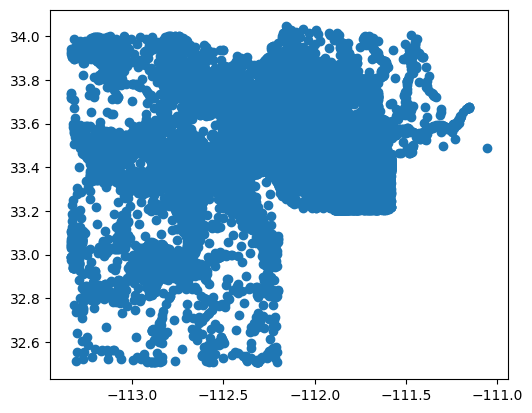

In [32]:
county_gdf = gdf[gdf['NAME2'] == f'{COUNTY} County']
if not county_gdf.empty:
    county_gdf.plot()
    plt.show()
else:
    print(f"No data found for '{COUNTY} County'.")

In [33]:
county_gdf.loc[:, 'school'] = county_gdf[['A00_04B', 'A05_09B', 'A10_14B', 'A15_19B']].sum(axis=1)
county_gdf.loc[:, 'adults'] = county_gdf[['A20_24B', 'A25_29B', 'A30_34B', 'A35_39B', 'A40_44B', 'A45_49B', 'A50_54B', 'A55_59B', 'A60_64B']].sum(axis=1)
county_gdf.loc[:, 'elder'] = county_gdf['A65PLUSB']
county_gdf.loc[:, 'Population'] = county_gdf[['A00_04B', 'A05_09B', 'A10_14B', 'A15_19B','A20_24B', 'A25_29B', 'A30_34B', 'A35_39B', 'A40_44B', 'A45_49B', 'A50_54B', 'A55_59B', 'A60_64B','A65PLUSB']].sum(axis=1)
county_gdf.loc[:, 'Population 2020'] = county_gdf['UN_2020_E']

# Reproject one of the GeoDataFrames if needed
census_block_groups = census_block_groups.to_crs(county_gdf.crs)

joined_gdf = gpd.sjoin(county_gdf, census_block_groups, how="inner", op="within")

aggregated_data = joined_gdf.groupby('index_right').agg({
    'Population 2020': lambda x: list(x),  # Aggregate populations into lists
    'geometry': lambda x: list(x)  # Aggregate geometries into lists
})

aggregated_data['Population'] = aggregated_data['Population 2020'].apply(np.array)
aggregated_data['geometry'] = aggregated_data['geometry'].apply(np.array)

census_block_groups['Point_Geometries'] = None
census_block_groups['Populations'] = None

for idx in aggregated_data.index:
    census_block_groups.at[idx, 'Point_Geometries'] = aggregated_data.at[idx, 'geometry']
    census_block_groups.at[idx, 'Populations'] = aggregated_data.at[idx, 'Population']
def calculate_weighted_social_centroid(df):
    df['Social_centroid'] = None  # Initialize the column for social centroids

    for idx, row in df.iterrows():
        # Explicitly check if 'Point_Geometries' and 'Populations' are not None or empty by comparing their lengths to zero
        if row['area km^2'] > 500 and row.get('Point_Geometries') is not None and len(row['Point_Geometries']) > 0 and row.get('Populations') is not None and len(row['Populations']) > 0:
            # Ensure 'Point_Geometries' and 'Populations' lists have the same length
            if len(row['Point_Geometries']) == len(row['Populations']):
                # Calculate weighted latitudes and longitudes
                weighted_latitudes = [point.y * population for point, population in zip(row['Point_Geometries'], row['Populations'])]
                weighted_longitudes = [point.x * population for point, population in zip(row['Point_Geometries'], row['Populations'])]
                # Calculate total population
                total_population = sum(row['Populations'])
                
                # Proceed if total population is greater than 0
                if total_population > 0:
                    mean_lat = sum(weighted_latitudes) / total_population
                    mean_lon = sum(weighted_longitudes) / total_population
                    # Assign the calculated Point as the social centroid
                    df.at[idx, 'Social_centroid'] = Point(mean_lon, mean_lat)

    return df

census_block_groups = calculate_weighted_social_centroid(census_block_groups)

/Users/alexandernez/Desktop/Github/Epymorph_vignettes/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/alexandernez/Desktop/Github/Epymorph_vignettes/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/Users/alexandernez/Desktop/Github/Epymorph_vignettes/.venv/lib/python3.11/site-packages/geopandas/geodataframe.py

In [59]:
################################# National Center for Education Statistics ################################################ 

directory = os.path.expanduser('~/Desktop/Github/EpiMoRPH-Modeling/social-determinate-of-health/scratch/Movement_model')  
file_configs = [
    {
        "file_path": "shapefiles/EDGE_GEOCODE_PUBLICSCH_1920/EDGE_GEOCODE_PUBLICSCH_1920.xlsx",  
        "dtype": {"CNTY": object},
        "usecols": ['NCESSCH', 'CNTY', 'STREET', 'CITY', 'ZIP', 'LAT', 'LON', 'SCHOOLYEAR'],
        "skip_rows": None
    },
    {
        "file_path": f"School_movement/NCES_public_schools_{STATE}.xltx",  
        "dtype": None,
        "usecols": ['NCES School ID', 'Low Grade*', 'High Grade*', 'School Name', 'District', 'Students*',
                    'Teachers*', 'Student Teacher Ratio*'],
        "skip_rows": 14
    },
    {
        "file_path": f"School_movement/NCES_public_schools_{STATE}.xltx",  
        "dtype": None,
        "usecols": ['NCES School ID', 'Low Grade', 'High Grade', 'School Name', 'District', 'Students',
                    'Teachers', 'Student Teacher Ratio'],
        "skip_rows": 11
    }
]

schools_location_df = read_excel_file(directory, file_configs[0]['file_path'], skip_rows=file_configs[0]['skip_rows'], dtype=file_configs[0]['dtype'], usecols=file_configs[0]['usecols'])

if STATE != 'AZ':
    schools_info_df = read_excel_file(directory, file_configs[1]['file_path'], 
                                      skip_rows=file_configs[1]['skip_rows'], 
                                      dtype=file_configs[1]['dtype'], 
                                      usecols=file_configs[1]['usecols'])

    schools_info_df['school type'] = schools_info_df.apply(
        lambda row: classify_school_type(row['Low Grade*'], row['High Grade*']), axis=1)
    schools_info_df['Students*'] = pd.to_numeric(schools_info_df['Students*'], errors='coerce')
else:
    schools_info_df = read_excel_file(directory, file_configs[2]['file_path'], 
                                      skip_rows=file_configs[2]['skip_rows'], 
                                      dtype=file_configs[2]['dtype'], 
                                      usecols=file_configs[2]['usecols'])
    schools_info_df['school type'] = schools_info_df.apply(
        lambda row: classify_school_type(row['Low Grade'], row['High Grade']), axis=1)
    schools_info_df['Students'] = pd.to_numeric(schools_info_df['Students'], errors='coerce')

NCES_public_schools_df = pd.merge(schools_info_df, schools_location_df, left_on='NCES School ID', right_on='NCESSCH')

NCES_public_schools_df = NCES_public_schools_df[NCES_public_schools_df['CNTY'] == CNTY]
NCES_public_schools_df.drop(columns=['NCESSCH'], inplace=True)

In [60]:
geometry = [Point(xy) for xy in zip(NCES_public_schools_df['LON'], NCES_public_schools_df['LAT'])]
gdf_public_schools = gpd.GeoDataFrame(NCES_public_schools_df, geometry=geometry).set_crs(epsg=4269, inplace=True)
gdf_public_schools = gdf_public_schools.set_crs(epsg=4269, inplace=True)

In [61]:
crs_to_use = 'EPSG:4269'  # Example CRS, choose as per your requirement
districts = districts.to_crs(crs_to_use)
census_block_groups = census_block_groups.to_crs(crs_to_use)
gdf_public_schools = gdf_public_schools.to_crs(crs_to_use)

# Perform overlays
intersection_area_cbg = gpd.overlay(census_block_groups, districts, how='intersection')

# Perform spatial joins with the predicate parameter
schools_in_intersection_cbg = gpd.sjoin(gdf_public_schools, intersection_area_cbg, how='inner', predicate='intersects')
schools_in_intersection_cbg['Students'] = pd.to_numeric(schools_in_intersection_cbg['Students'], errors='coerce')


In [62]:
census_block_groups = census_block_groups.to_crs(epsg=4326) 

In [63]:
projected_crs = 'EPSG:26912'

percentage_results = []

for idx, tract in census_block_groups.iterrows():
    tract_gdf = gpd.GeoDataFrame([tract], geometry='geometry', crs=census_block_groups.crs)
    tract_gdf_projected = tract_gdf.to_crs(projected_crs)
    intersection_result = gpd.overlay(tract_gdf_projected, districts.to_crs(projected_crs), how='intersection')

    for idx, district in intersection_result.iterrows():
        intersection_area = district.geometry.area
        total_tract_area = tract_gdf_projected.geometry.area.iloc[0] if tract_gdf_projected.geometry.area.iloc[0] > 0 else 1.0
        percentage_within_district = (intersection_area / total_tract_area) * 100
        
        percentage_results.append({
            'GEOID': tract['GEOID'],  
            'ElemDist': district['ElemDist'],  
            'PercentageWithinDistrict': percentage_within_district,
        })

In [ ]:
precentage_schools = schools_in_intersection_cbg[['NCES School ID', 'GEOID','ElemDist', 'School Name', 'Students', 'school type']]

In [ ]:
percentage_results_df = pd.DataFrame(percentage_results)

pivoted_df = percentage_results_df.pivot_table(index='GEOID', columns='ElemDist', values='PercentageWithinDistrict', aggfunc='mean')
pivoted_df = pivoted_df.fillna(0)
pivoted_df = pivoted_df.reset_index()
pivoted_df.iloc[:, 1:] = pivoted_df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
pivoted_df['Tract School District'] = pivoted_df.iloc[:, 1:].idxmax(axis=1)

color_mapping = dict(zip(district['ElemDist'], district['color']))
pivoted_df['precent color'] = pivoted_df['Tract School District'].map(color_mapping)


data_df_1 = pivoted_df[["GEOID", "Tract School District", "precent color"]]
census_block_groups = pd.merge(census_block_groups, pivoted_df, on='GEOID', how='left')

merged_df = census_block_groups

# Merge with precentage_schools
census_block_groups = pd.merge(census_block_groups, precentage_schools, on='GEOID', how='left')

# Fill NaN values with 0 and drop duplicates based on 'GEOID'
census_block_groups.fillna(0, inplace=True)
census_block_groups.drop_duplicates(subset=['GEOID'], inplace=True)

percentage_gpd_df = gpd.GeoDataFrame(census_block_groups).reset_index()

In [ ]:
num_census_blocks = len(percentage_gpd_df['label'])
num_schools = len(schools_in_intersection_cbg)

nearest_school = np.zeros((num_census_blocks, num_schools))
School_names = schools_in_intersection_cbg['School Name'].tolist()
school_ids = range(1, num_schools)

In [ ]:
schools_in_intersection_cbg.sort_values(by='ElemDist', inplace=True)

current_district = None
adjustment_factor = 1.0
increment = 0.05 

schools_in_intersection_cbg['school_color'] = None

for idx, row in schools_in_intersection_cbg.iterrows():
    if row['ElemDist'] != current_district:
        current_district = row['ElemDist']
        adjustment_factor = 1.0
    else:
        adjustment_factor += increment
    
    schools_in_intersection_cbg.at[idx, 'school_color'] = adjust_lightness(row['color'], amount=adjustment_factor)

schools_in_intersection_cbg[['ElemDist', 'School Name', 'color', 'school_color']]

In [ ]:
num_census_blocks = len(percentage_gpd_df['label'])
num_schools = len(schools_in_intersection_cbg)

nearest_school = np.zeros((num_census_blocks, num_schools))
School_names = schools_in_intersection_cbg['School Name'].tolist()
school_ids = range(1, num_schools)

In [ ]:
preschools = schools_in_intersection_cbg[
    schools_in_intersection_cbg['school type'].isin(['Preschool'])]
preschools_names = preschools['School Name'].tolist()

elementary_schools = schools_in_intersection_cbg[
    schools_in_intersection_cbg['school type'].isin(['Elementary School', 'Elementary/Middle School', 'Elementary/Middle/High School'])]
elementary_schools_names = elementary_schools['School Name'].tolist()

middle_schools = schools_in_intersection_cbg[
    schools_in_intersection_cbg['school type'].isin(['Middle School', 'Elementary/Middle School', 'Middle/High School', 'Elementary/Middle/High School'])]
middle_schools_names = middle_schools['School Name'].tolist()

high_schools = schools_in_intersection_cbg[
    schools_in_intersection_cbg['school type'].isin(['High School', 'Middle/High School', 'Elementary/Middle/High School'])]
high_schools_names = high_schools['School Name'].tolist()

In [ ]:
num_preschools = len(preschools)
num_elementary_schools = len(elementary_schools)
num_middle_schools = len(middle_schools)
num_high_schools = len(high_schools)

nearest_preschools = np.zeros((num_census_blocks, num_preschools))
nearest_elementary_schools = np.zeros((num_census_blocks, num_elementary_schools))
nearest_middle_schools = np.zeros((num_census_blocks, num_middle_schools))
nearest_high_schools= np.zeros((num_census_blocks, num_high_schools))

students_preschools = np.zeros((num_census_blocks, num_preschools))
students_elementary_schools = np.zeros((num_census_blocks, num_elementary_schools))
students_middle_schools = np.zeros((num_census_blocks, num_middle_schools))
students_high_schools= np.zeros((num_census_blocks, num_high_schools))

In [ ]:
labels = percentage_gpd_df['label'].tolist()

matrix_df = pd.DataFrame(0, index=labels, columns=labels)
matrix_df

In [ ]:
for i in range(num_census_blocks):
    tract_district = percentage_gpd_df['Tract School District'][i]
    student_home_cbg = percentage_gpd_df['GEOID'][i]
    students_population_cbg = percentage_gpd_df['population_by_age'][i][:3]
    
    for j in range(num_preschools):
        school_district = preschools['ElemDist'].iloc[j]
        school_district_cbg = preschools['GEOID'].iloc[j]
        school_district_population = preschools['Students'].iloc[j]

        if tract_district == school_district:
            try:
                nearest_preschools[i, j] = haversine(percentage_gpd_df['centroid'][i][0], 
                                                            percentage_gpd_df['centroid'][i][1],
                                                            preschools['coords'].iloc[j][0], 
                                                            preschools['coords'].iloc[j][1])
                matrix_df.at[student_home_cbg, school_district_cbg] = students_population_cbg[0]

            except KeyError:
                print(f"KeyError encountered at index: {j}")
        else:
            nearest_elementary_schools[i, j] = None

    for j in range(num_elementary_schools):
        school_district = elementary_schools['ElemDist'].iloc[j]
        school_district_cbg = elementary_schools['GEOID'].iloc[j]
        school_district_population = elementary_schools['Students'].iloc[j]

        if tract_district == school_district:
            try:
                nearest_elementary_schools[i, j] = haversine(percentage_gpd_df['centroid'][i][0], 
                                                            percentage_gpd_df['centroid'][i][1],
                                                            elementary_schools['coords'].iloc[j][0], 
                                                            elementary_schools['coords'].iloc[j][1])
                matrix_df.at[student_home_cbg, school_district_cbg] = students_population_cbg[0]

            except KeyError:
                print(f"KeyError encountered at index: {j}")
        else:
            nearest_elementary_schools[i, j] = None
    for j in range(num_middle_schools):
        school_district = middle_schools['ElemDist'].iloc[j]
        school_district_cbg = middle_schools['GEOID'].iloc[j]
        school_district_population = middle_schools['Students'].iloc[j]

        if tract_district == school_district:
            try:
                nearest_middle_schools[i, j] = haversine(percentage_gpd_df['centroid'][i][0], 
                                                            percentage_gpd_df['centroid'][i][1],
                                                            middle_schools['coords'].iloc[j][0], 
                                                            middle_schools['coords'].iloc[j][1])
                matrix_df.at[student_home_cbg, school_district_cbg] = students_population_cbg[1].sum()
            except KeyError:
                print(f"KeyError encountered at index: {j}")
        else:
            nearest_middle_schools[i, j] = None

    for j in range(num_high_schools):
        school_district = high_schools['ElemDist'].iloc[j]
        school_district_cbg = high_schools['GEOID'].iloc[j]
        school_district_population = high_schools['Students'].iloc[j]

        if tract_district == school_district:
            try:
                nearest_middle_schools[i, j] = haversine(percentage_gpd_df['centroid'][i][0], 
                                                            percentage_gpd_df['centroid'][i][1],
                                                            high_schools['coords'].iloc[j][0], 
                                                            high_schools['coords'].iloc[j][1])
                matrix_df.at[student_home_cbg, school_district_cbg] = students_population_cbg[1].sum()
            except KeyError:
                print(f"KeyError encountered at index: {j}")
        else:
            nearest_high_schools[i, j] = None

In [ ]:
def get_nearest_school(df):
    if df.empty or df.isna().all().all():
        return pd.Series([None] * len(df), index=df.index)
    else:
        return df.idxmin(axis=1)

nearest_elementary_school_df = pd.DataFrame(nearest_elementary_schools, columns = elementary_schools_names)
nearest_middle_school_df = pd.DataFrame(nearest_middle_schools, columns = middle_schools_names)
nearest_high_schools_df = pd.DataFrame(nearest_high_schools, columns = high_schools_names)

nearest_elementary = get_nearest_school(nearest_elementary_school_df)
nearest_middle = get_nearest_school(nearest_middle_school_df)
nearest_high = get_nearest_school(nearest_high_schools_df)

closest_elementary_df = pd.DataFrame(nearest_elementary, columns=["Elementary School Name"])
closest_middle_df = pd.DataFrame(nearest_middle, columns=[" Middle School Name"])
closest_high_df = pd.DataFrame(nearest_high, columns=["High School Name"])

In [ ]:
data_df = pd.concat([percentage_gpd_df, closest_elementary_df, closest_middle_df, closest_high_df ], axis=1)

percentage_Voronoi_gpd = gpd.GeoDataFrame(data_df)

In [ ]:
####################################################### School Vaccine #########################################################

School_path = os.path.expanduser('~/Desktop/Github/Epymorph_vignettes/scratch/Measles_school_coverage.csv')
Measles_school_coverage = pd.read_csv(School_path, dtype={'GEOID': str})
Measles_school_coverage

In [ ]:
########################################################################################################################
dir_path = os.path.expanduser('~/Desktop/Github/EpiMoRPH-Modeling/social-determinate-of-health/scratch/Movement_model')
filename = 'matrix_array.npy'
file_path = os.path.join(dir_path, filename)

loaded_array = np.load(file_path)

# Testing Begins


IndexError: list index out of range

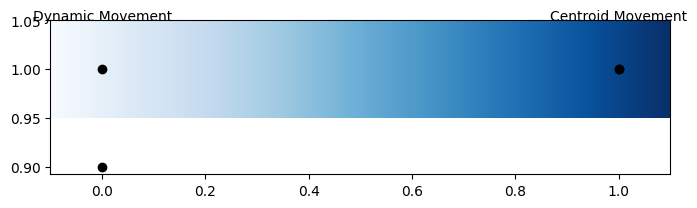

In [71]:
import matplotlib.pyplot as plt
import numpy as np
w = [0., 1]
x = [0, 1]  
y = [1, 1]  
z = [0.9, 1]
labels = ['Dynamic Movement','Centroid Movement', 'Commuter Movement', 'School Movement']

fig, ax = plt.subplots(figsize=(8, 2))

cmap = plt.get_cmap('Blues')
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

ax.imshow(gradient, aspect='auto', cmap=cmap, extent=[-0.1, 1.1, 0.95, 1.05])

ax.plot(x, y, 'o', color='black') 
ax.plot(w, z, 'o', color='black') 

for i, label in enumerate(labels):
    ax.text(x[i], y[i] + 0.05, label, ha='center')

ax.set_xlim(-0.1, 1.1)

ax.set_xticks([0, 1])
ax.set_xticklabels(['Not Realistic', 'Realistic'])

ax.set_yticks([])

ax.axis('off')

ax.set_title('Realism Scale', pad=20)

plt.show()



In [ ]:
from epymorph.geo.spec import (LABEL, AttribDef, CentroidDType, StaticGeoSpec,
                               Year)

cpu_75 = int(multiprocessing.cpu_count() \* 0.75) # Using 6 CPU cores


In [ ]:
import multiprocessing

In [ ]:
from multiprocessing import Pool, get_context


In [ ]:
cpu_75 = int(multiprocessing.cpu_count() * 0.75) # Using 6 CPU cores


In [ ]:
def read_parquet():
    start_time = time.time()
    gdf = gpd.read_parquet(parquet_path)
    end_time = time.time()
    return end_time - start_time

In [37]:
county_gdf

,GUBID,ISOALPHA,COUNTRYNM,NAME1,NAME2,NAME3,NAME4,NAME5,NAME6,CENTROID_X,...,A75_79M,A80PLUSM,A80_84M,A85PLUSM,geometry,school,adults,elder,Population,Population 2020
68707,{A595A3F9-951B-4E5B-A345-A24DADEB589B},USA,United States of America,Arizona,Maricopa County,Census Tract 6106,Block Group 3,Block 3004,NA,-112.124130,...,0.0,0.0,0.0,0.0,POINT (-112.12413 33.80274),7.0,11.0,1.0,19.0,23
68708,{E39F9C25-54F2-4C41-AAAB-12EEE1AB8241},USA,United States of America,Arizona,Maricopa County,Census Tract 6100,Block Group 4,Block 4012,NA,-112.159029,...,0.0,0.0,0.0,0.0,POINT (-112.15903 33.86704),30.0,43.0,3.0,76.0,92
68709,{FE6E4099-31DD-4C54-80E8-F88F455292E5},USA,United States of America,Arizona,Maricopa County,Census Tract 6100,Block Group 4,Block 4029,NA,-112.157291,...,0.0,0.0,0.0,0.0,POINT (-112.15729 33.86669),24.0,39.0,0.0,63.0,76
68710,{E583D4AE-83FB-4AAD-AB19-BE135FBFB738},USA,United States of America,Arizona,Maricopa County,Census Tract 6100,Block Group 4,Block 4004,NA,-112.157097,...,0.0,0.0,0.0,0.0,POINT (-112.15710 33.87047),12.0,37.0,2.0,51.0,62
68711,{06767313-659D-435C-896B-A2FEE28C5421},USA,United States of America,Arizona,Maricopa County,Census Tract 6100,Block Group 4,Block 4008,NA,-112.154604,...,1.0,0.0,0.0,0.0,POINT (-112.15460 33.86498),25.0,21.0,2.0,48.0,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141431,{167A9F79-144F-4B67-B76B-7477A9A0649F},USA,United States of America,Arizona,Maricopa County,Census Tract 4224.02,Block Group 3,Block 3016,NA,-111.783745,...,0.0,0.0,0.0,0.0,POINT (-111.78375 33.35179),19.0,41.0,7.0,67.0,81
141432,{CCB5A50A-0579-47C6-99B8-AF33B0AB3F71},USA,United States of America,Arizona,Maricopa County,Census Tract 4224.02,Block Group 3,Block 3022,NA,-111.785462,...,2.0,0.0,0.0,0.0,POINT (-111.78546 33.35242),21.0,46.0,6.0,73.0,88
141433,{EC024ABD-E10D-4BF8-BB94-93E357D838AF},USA,United States of America,Arizona,Maricopa County,Census Tract 4224.02,Block Group 3,Block 3009,NA,-111.782991,...,1.0,0.0,0.0,0.0,POINT (-111.78299 33.35320),17.0,36.0,10.0,63.0,76
141434,{8C9352BB-0D19-4006-94C6-36D182BB26A0},USA,United States of America,Arizona,Maricopa County,Census Tract 4224.02,Block Group 3,Block 3011,NA,-111.787485,...,0.0,0.0,0.0,0.0,POINT (-111.78748 33.35319),25.0,33.0,6.0,64.0,77


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/pool.py:48: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return list(map(*args))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/pool.py:48: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return list(map(*args))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/pool.py:48: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  return list(map(*args))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/pool.py:48: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  retu

Mean duration: 9.2243 seconds
Median duration: 9.3371 seconds
Standard deviation: 3.1060 seconds


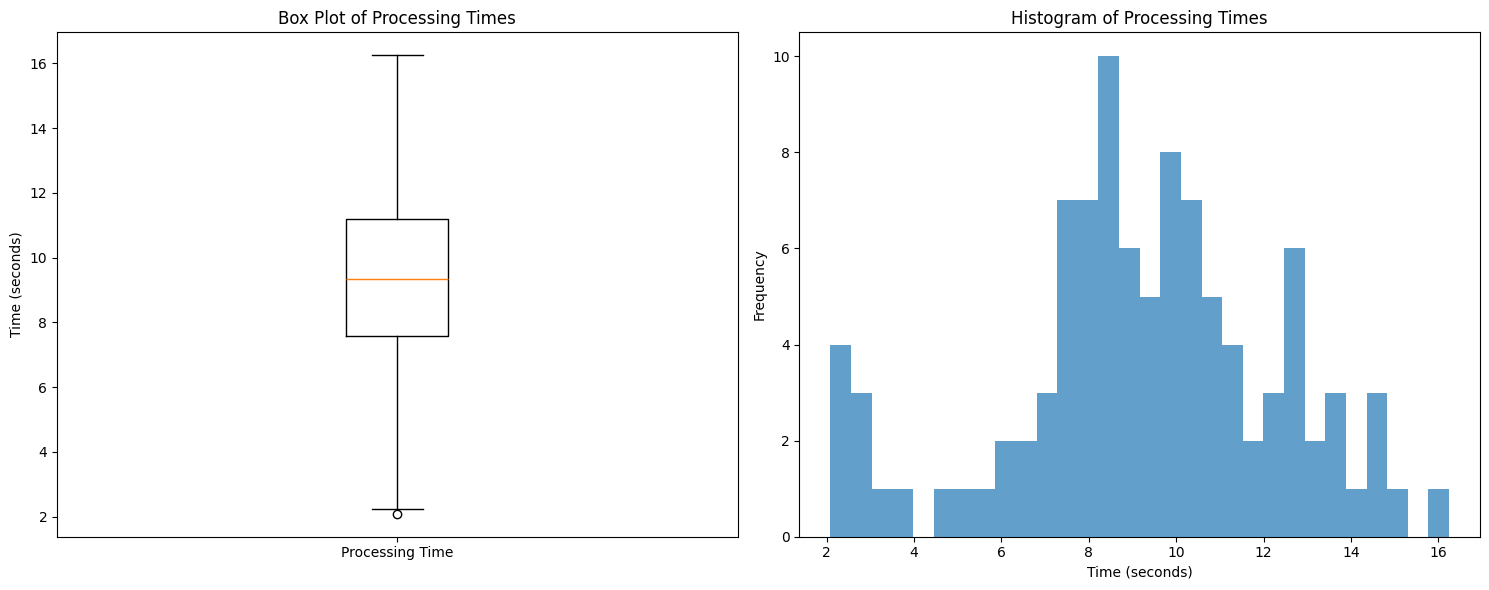

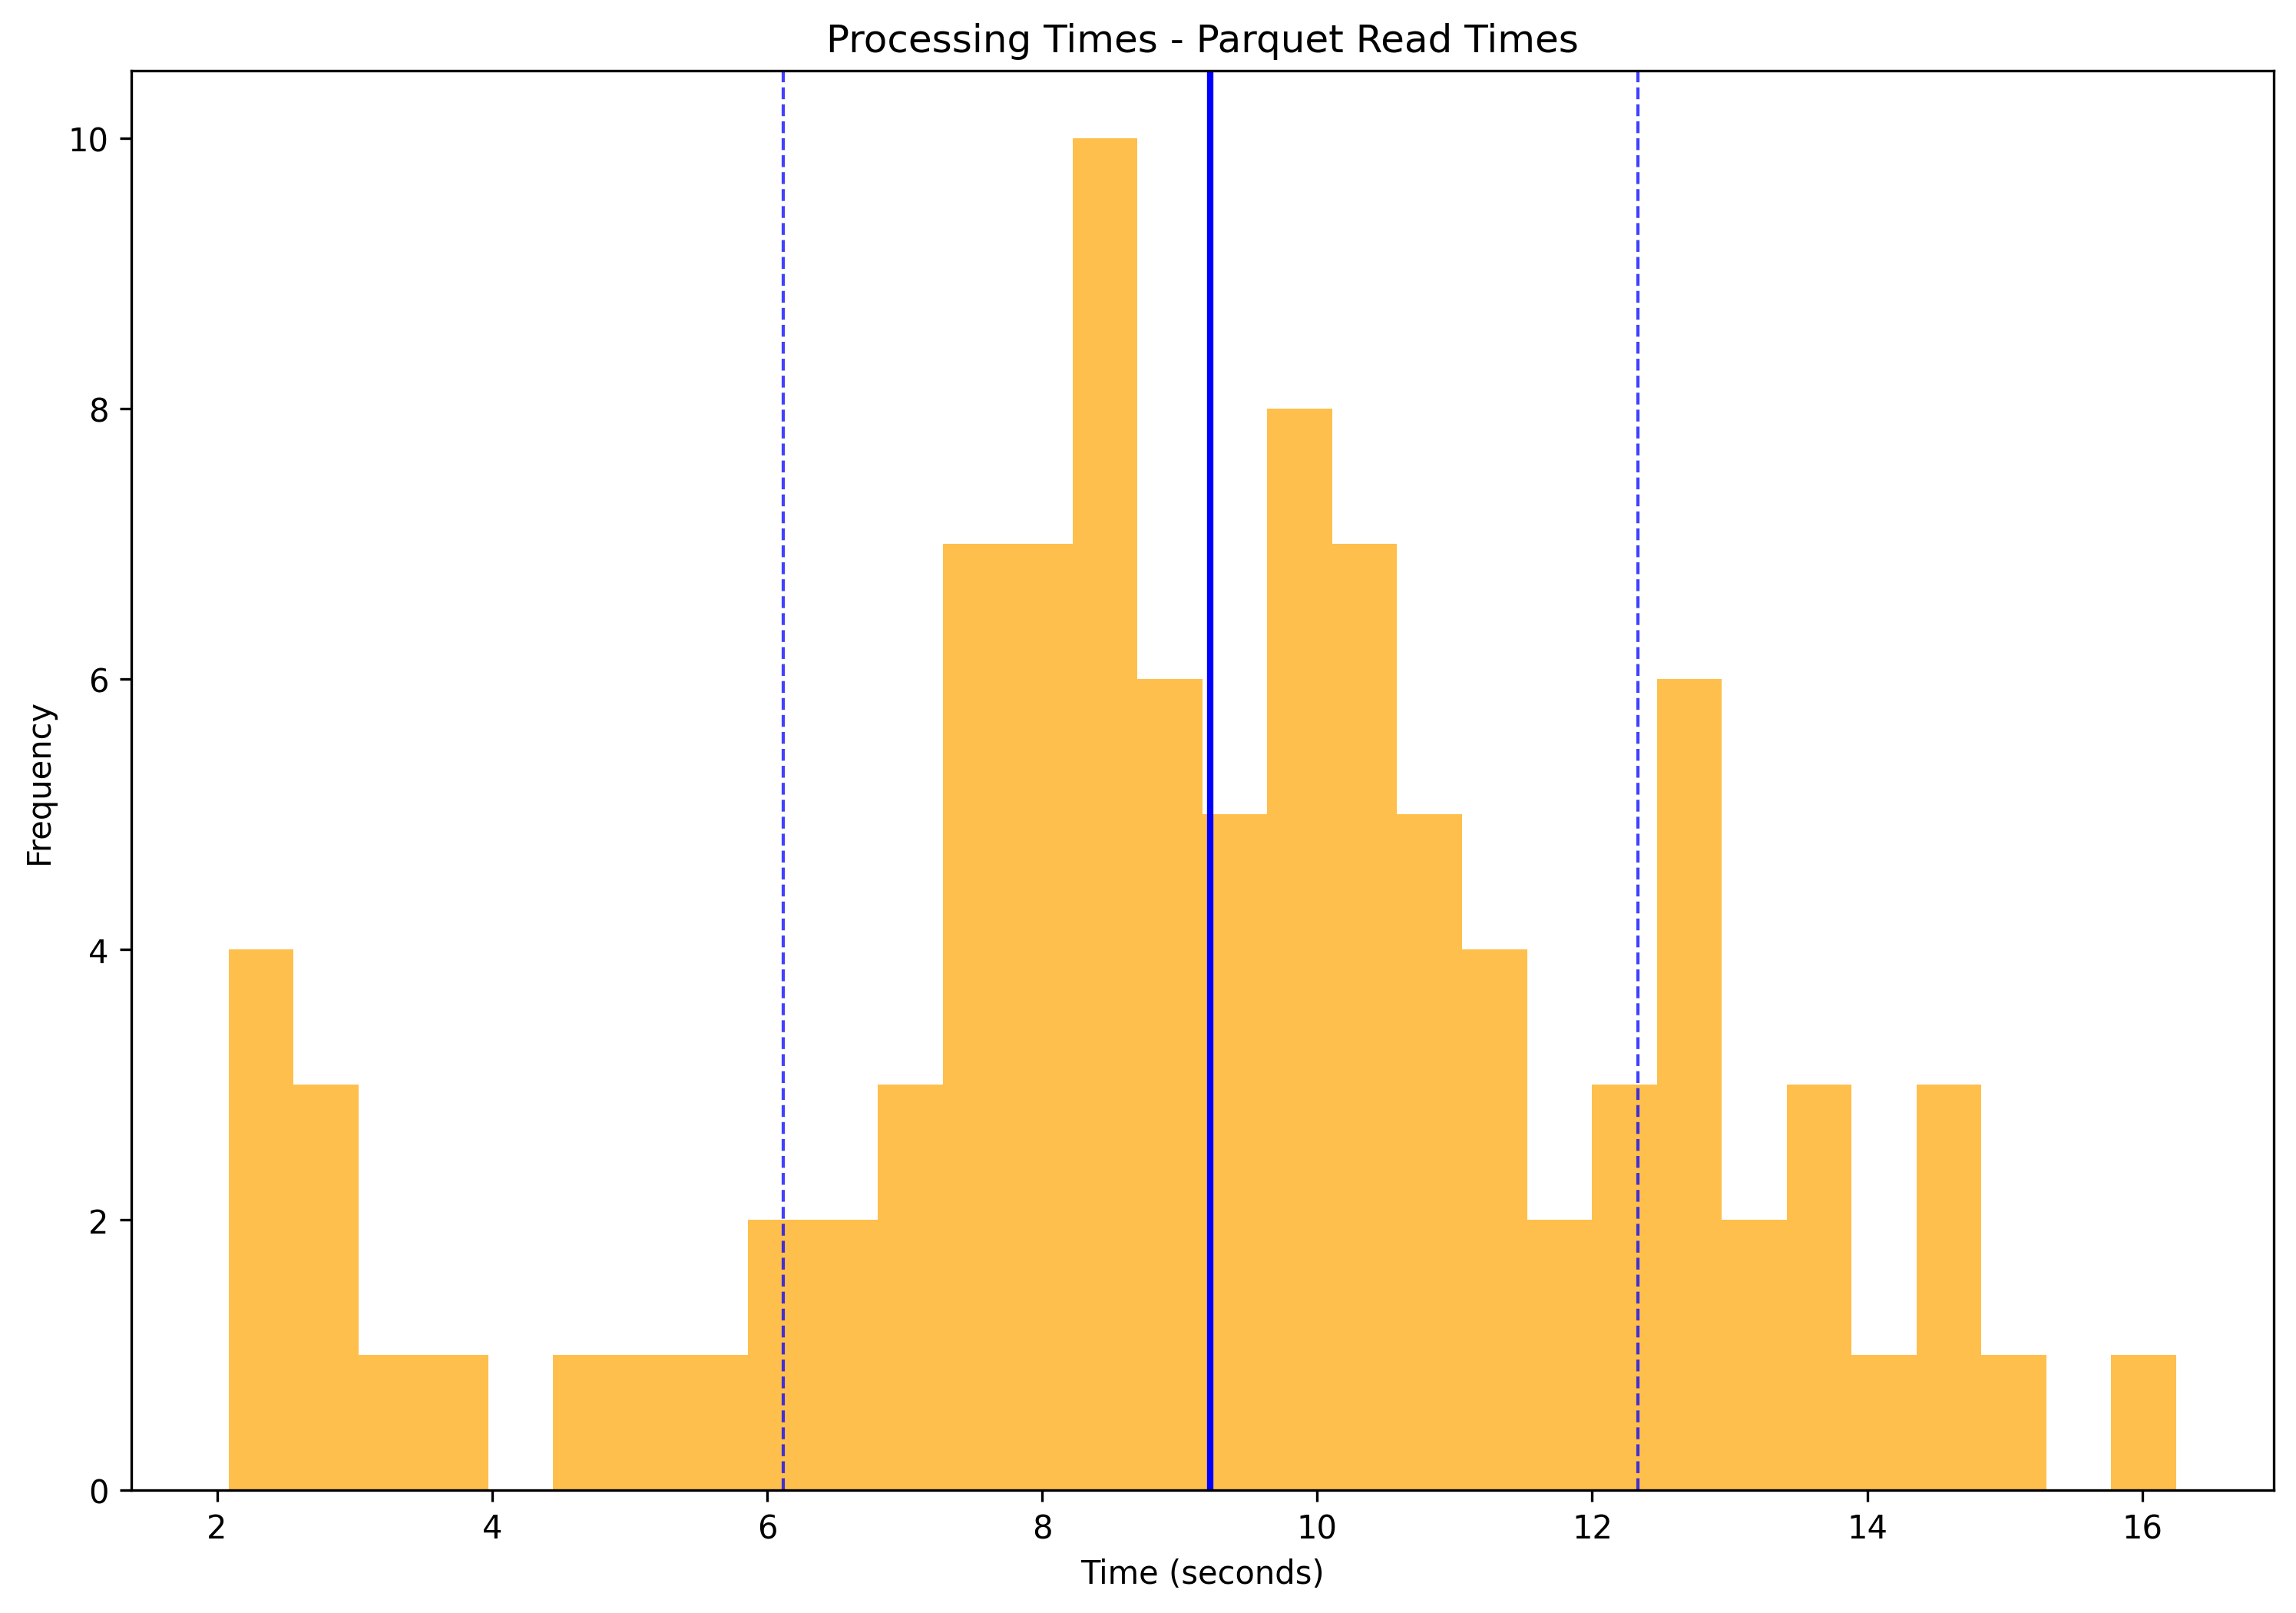

In [58]:
import time
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from multiprocessing import Pool, get_context
import os

def process_data(dummy_arg):
    county_gdf = dummy_arg[0]
    census_block_groups = dummy_arg[1]
    gdf = gpd.read_parquet(parquet_path)
    county_gdf.loc[:, 'school'] = county_gdf[['A00_04B', 'A05_09B', 'A10_14B', 'A15_19B']].sum(axis=1)
    county_gdf.loc[:, 'adults'] = county_gdf[['A20_24B', 'A25_29B', 'A30_34B', 'A35_39B', 'A40_44B', 'A45_49B', 'A50_54B', 'A55_59B', 'A60_64B']].sum(axis=1)
    county_gdf.loc[:, 'elder'] = county_gdf['A65PLUSB']
    county_gdf.loc[:, 'Population'] = county_gdf[['A00_04B', 'A05_09B', 'A10_14B', 'A15_19B','A20_24B', 'A25_29B', 'A30_34B', 'A35_39B', 'A40_44B', 'A45_49B', 'A50_54B', 'A55_59B', 'A60_64B','A65PLUSB']].sum(axis=1)
    county_gdf.loc[:, 'Population 2020'] = county_gdf['UN_2020_E']

    # Reproject one of the GeoDataFrames if needed
    census_block_groups = census_block_groups.to_crs(county_gdf.crs)

    joined_gdf = gpd.sjoin(county_gdf, census_block_groups, how="inner", op="within")

    aggregated_data = joined_gdf.groupby('index_right').agg({
        'Population 2020': lambda x: list(x),  # Aggregate populations into lists
        'geometry': lambda x: list(x)  # Aggregate geometries into lists
    })

    aggregated_data['Population'] = aggregated_data['Population 2020'].apply(np.array)
    aggregated_data['geometry'] = aggregated_data['geometry'].apply(np.array)

    census_block_groups['Point_Geometries'] = None
    census_block_groups['Populations'] = None

    for idx in aggregated_data.index:
        census_block_groups.at[idx, 'Point_Geometries'] = aggregated_data.at[idx, 'geometry']
        census_block_groups.at[idx, 'Populations'] = aggregated_data.at[idx, 'Population']

    def calculate_weighted_social_centroid(df):
        df['Social_centroid'] = None  # Initialize the column for social centroids

        for idx, row in df.iterrows():
            # Explicitly check if 'Point_Geometries' and 'Populations' are not None or empty by comparing their lengths to zero
            if row['area km^2'] > 500 and row.get('Point_Geometries') is not None and len(row['Point_Geometries']) > 0 and row.get('Populations') is not None and len(row['Populations']) > 0:
                # Ensure 'Point_Geometries' and 'Populations' lists have the same length
                if len(row['Point_Geometries']) == len(row['Populations']):
                    # Calculate weighted latitudes and longitudes
                    weighted_latitudes = [point.y * population for point, population in zip(row['Point_Geometries'], row['Populations'])]
                    weighted_longitudes = [point.x * population for point, population in zip(row['Point_Geometries'], row['Populations'])]
                    # Calculate total population
                    total_population = sum(row['Populations'])

                    # Proceed if total population is greater than 0
                    if total_population > 0:
                        mean_lat = sum(weighted_latitudes) / total_population
                        mean_lon = sum(weighted_longitudes) / total_population
                        # Assign the calculated Point as the social centroid
                        df.at[idx, 'Social_centroid'] = Point(mean_lon, mean_lat)

        return df

    census_block_groups = calculate_weighted_social_centroid(census_block_groups)

    return census_block_groups

def measure_time(dummy_arg):
    start_time = time.time()
    process_data(dummy_arg)
    end_time = time.time()
    return end_time - start_time

# Use multiprocessing to run the function 100 times
cpu_75 = int(0.75 * os.cpu_count())
with get_context("fork").Pool(cpu_75) as pool:
    durations = pool.map(measure_time, [(county_gdf, census_block_groups)] * 100)

# Calculate statistics
mean_duration = np.mean(durations)
median_duration = np.median(durations)
std_dev_duration = np.std(durations)

print(f"Mean duration: {mean_duration:.4f} seconds")
print(f"Median duration: {median_duration:.4f} seconds")
print(f"Standard deviation: {std_dev_duration:.4f} seconds")

# Plotting the results
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Box plot
ax[0].boxplot(durations, labels=['Processing Time'])
ax[0].set_title('Box Plot of Processing Times')
ax[0].set_ylabel('Time (seconds)')

# Histogram
ax[1].hist(durations, bins=30, alpha=0.7)
ax[1].set_title('Histogram of Processing Times')
ax[1].set_xlabel('Time (seconds)')
ax[1].set_ylabel('Frequency')


plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8), dpi = 300)
plt.hist(durations, bins=30, alpha=0.7, color='orange')
plt.title('Processing Times - Parquet Read Times')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')

    # Plot mean duration as a vertical line
plt.axvline(mean_duration, color='blue', linestyle='-', linewidth=2)

    # Plot +/- 1 standard deviation as vertical lines
plt.axvline(mean_duration + std_dev_duration, color='blue', alpha = 0.75, linestyle='--', linewidth=1)
plt.axvline(mean_duration - std_dev_duration, color='blue', alpha = 0.75, linestyle='--', linewidth=1)

plt.show()


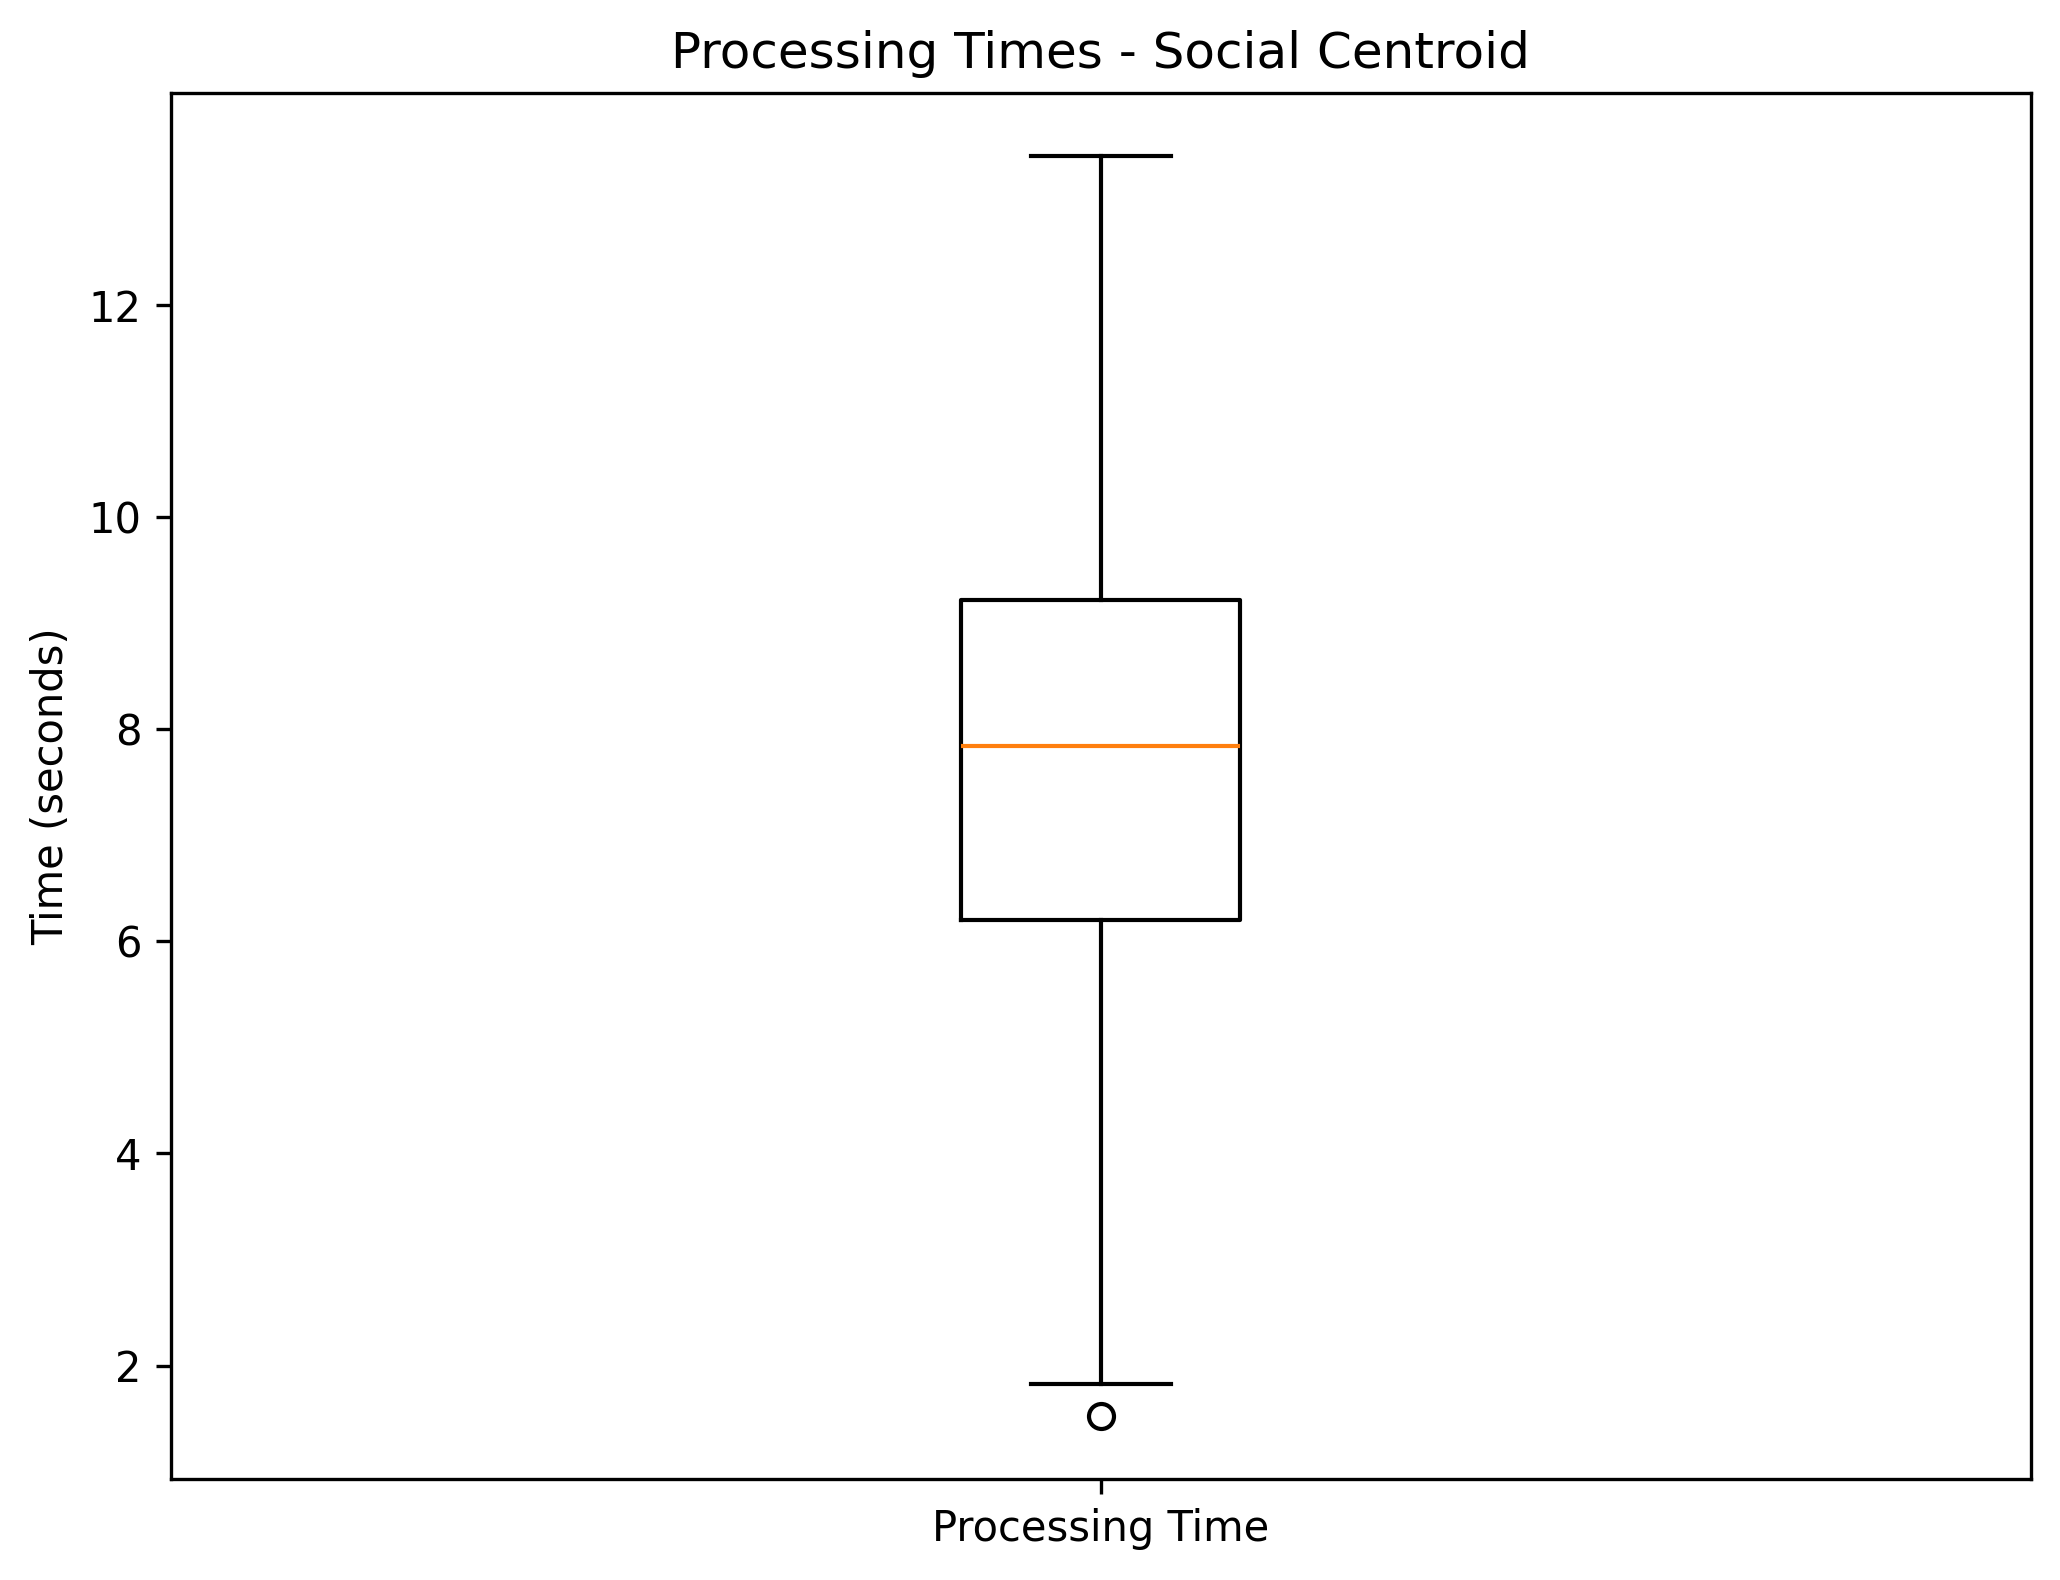

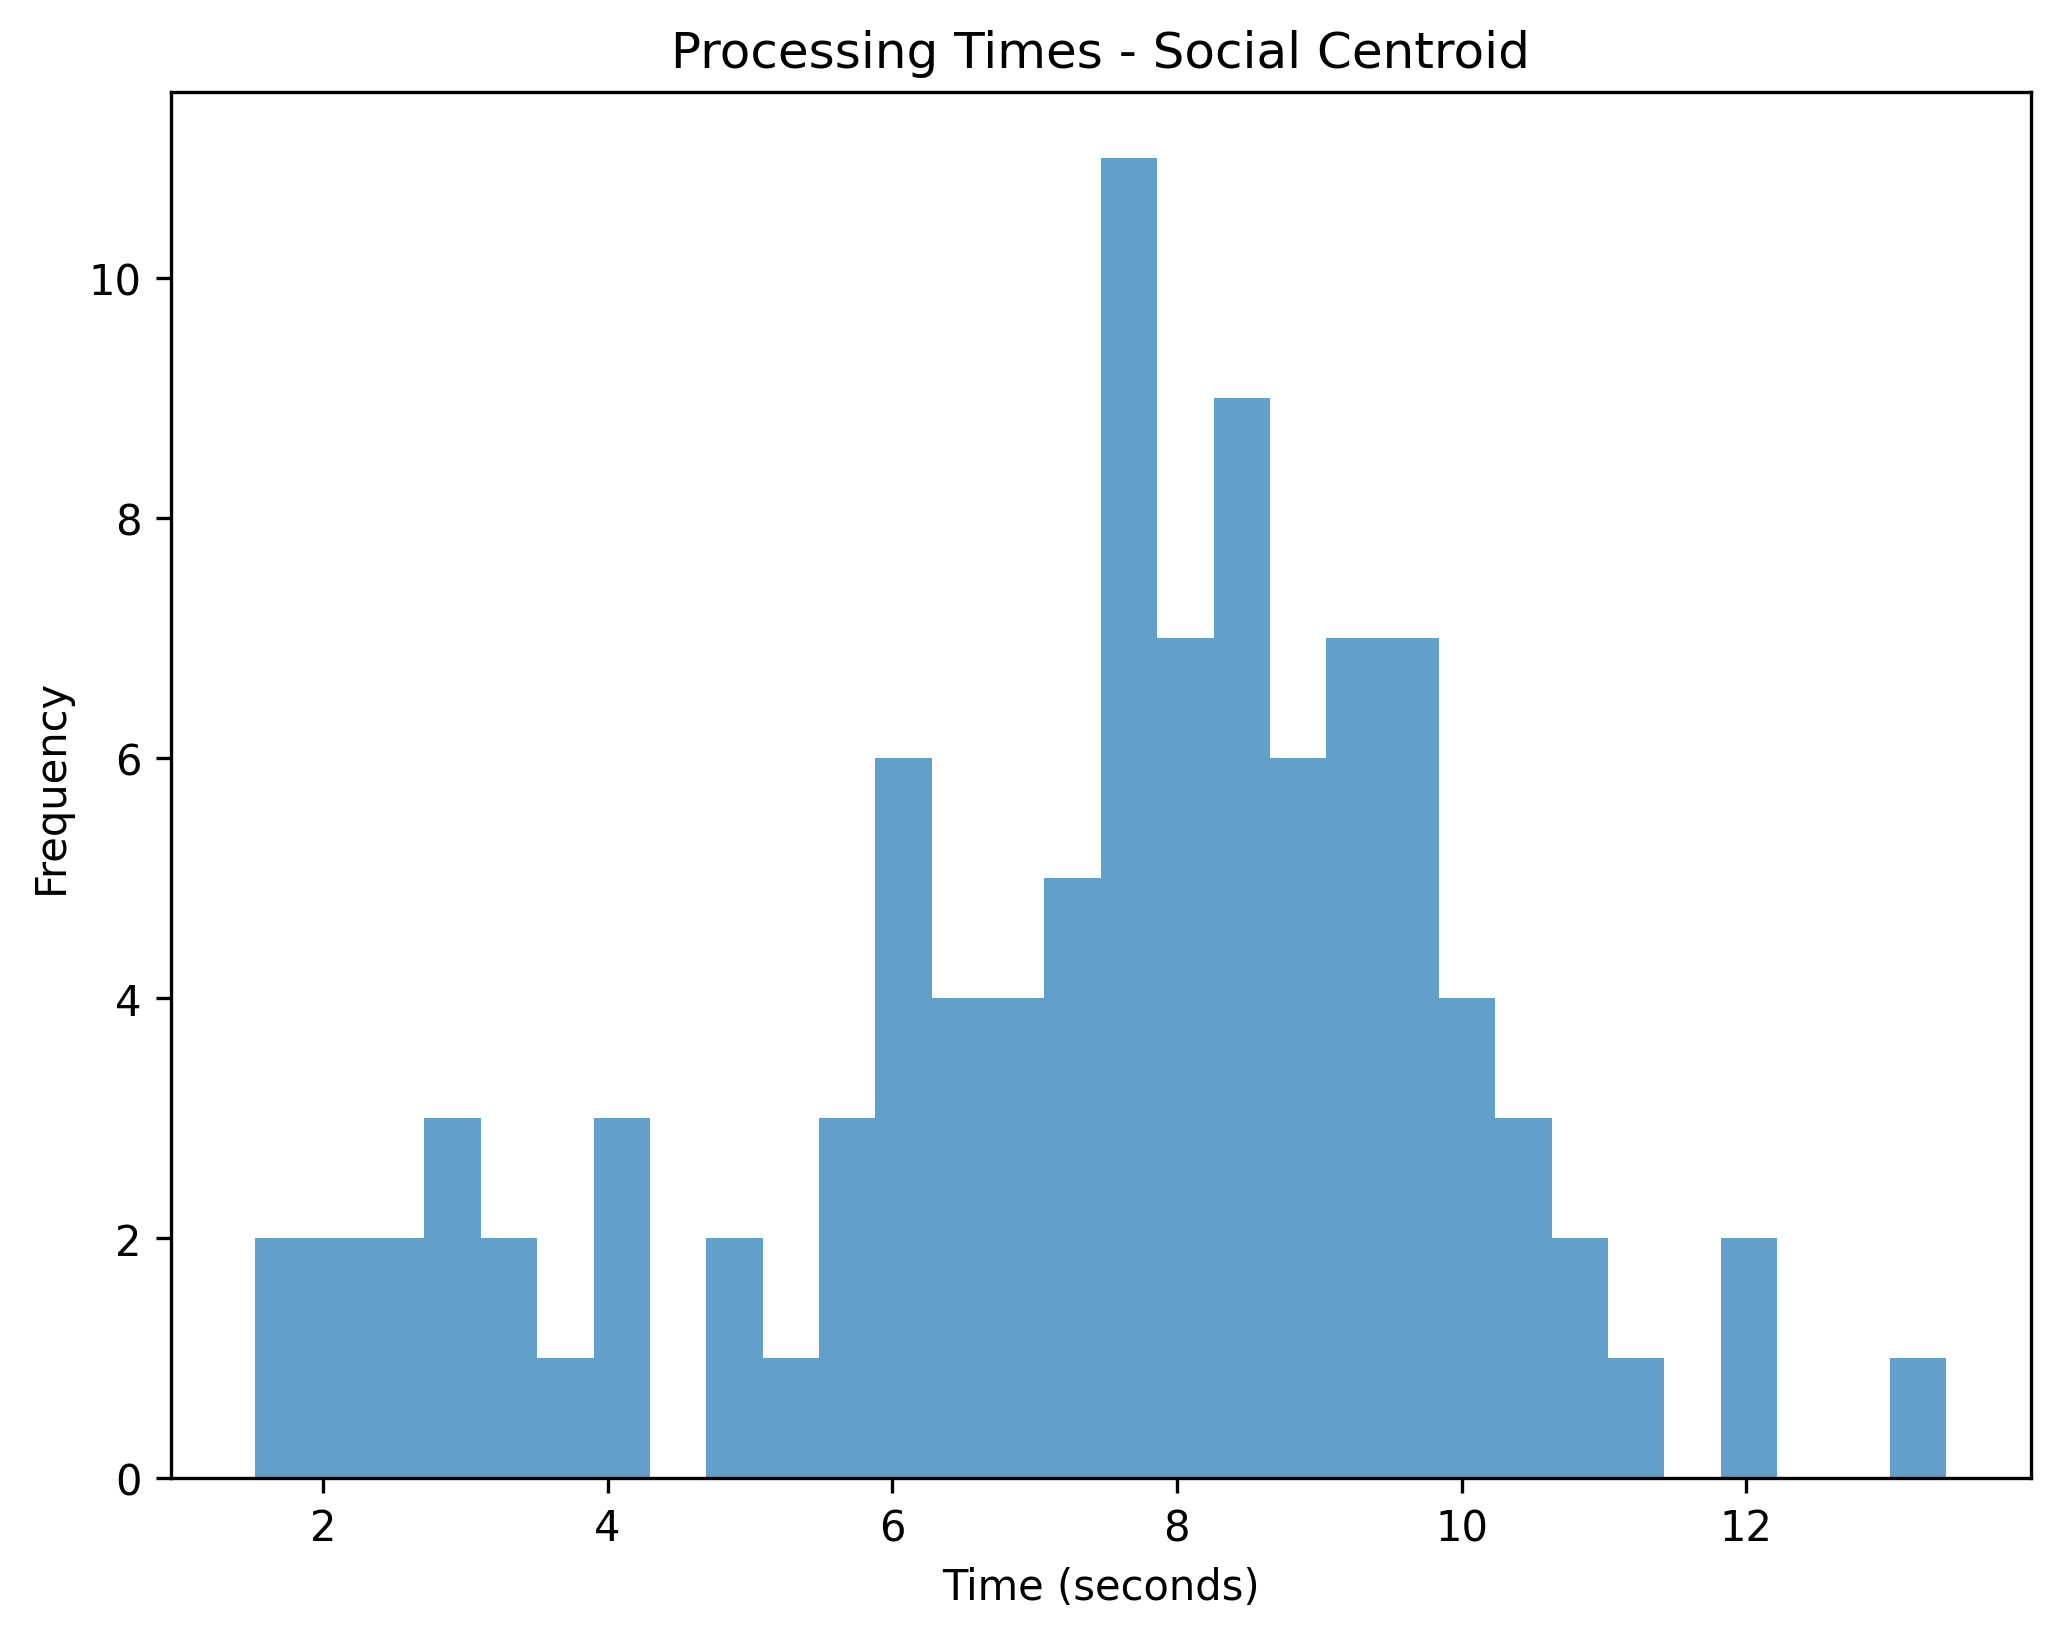

In [38]:
# Box plot
plt.figure(figsize=(8, 6), dpi = 300)
plt.boxplot(durations, labels=['Processing Time'])
plt.title('Processing Times - Social Centroid')
plt.ylabel('Time (seconds)')
plt.show()

# Histogram
plt.figure(figsize=(8, 6), dpi = 300)
plt.hist(durations, bins=30, alpha=0.7)
plt.title('Processing Times - Social Centroid')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')
plt.show()


In [ ]:
plt.figure(figsize=(12, 8), dpi = 300)
plt.hist(durations, bins=30, alpha=0.7, color='orange')
plt.title('Processing Times - Social Centroid')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')

# Plot mean duration as a vertical line
plt.axvline(mean_duration, color='blue', linestyle='-', linewidth=2)

# Plot +/- 1 standard deviation as vertical lines
plt.axvline(mean_duration + std_dev_duration, color='blue', alpha = 0.75, linestyle='--', linewidth=1)
plt.axvline(mean_duration - std_dev_duration, color='blue', alpha = 0.75, linestyle='--', linewidth=1)

plt.show()

In [ ]:
cpu_75 = int(0.75 * os.cpu_count())
cpu_75

Starting looping...
Looping completed.
Parquet Read - Mean duration: 0.4265 seconds
Parquet Read - Median duration: 0.4147 seconds
Parquet Read - Standard deviation: 0.1073 seconds


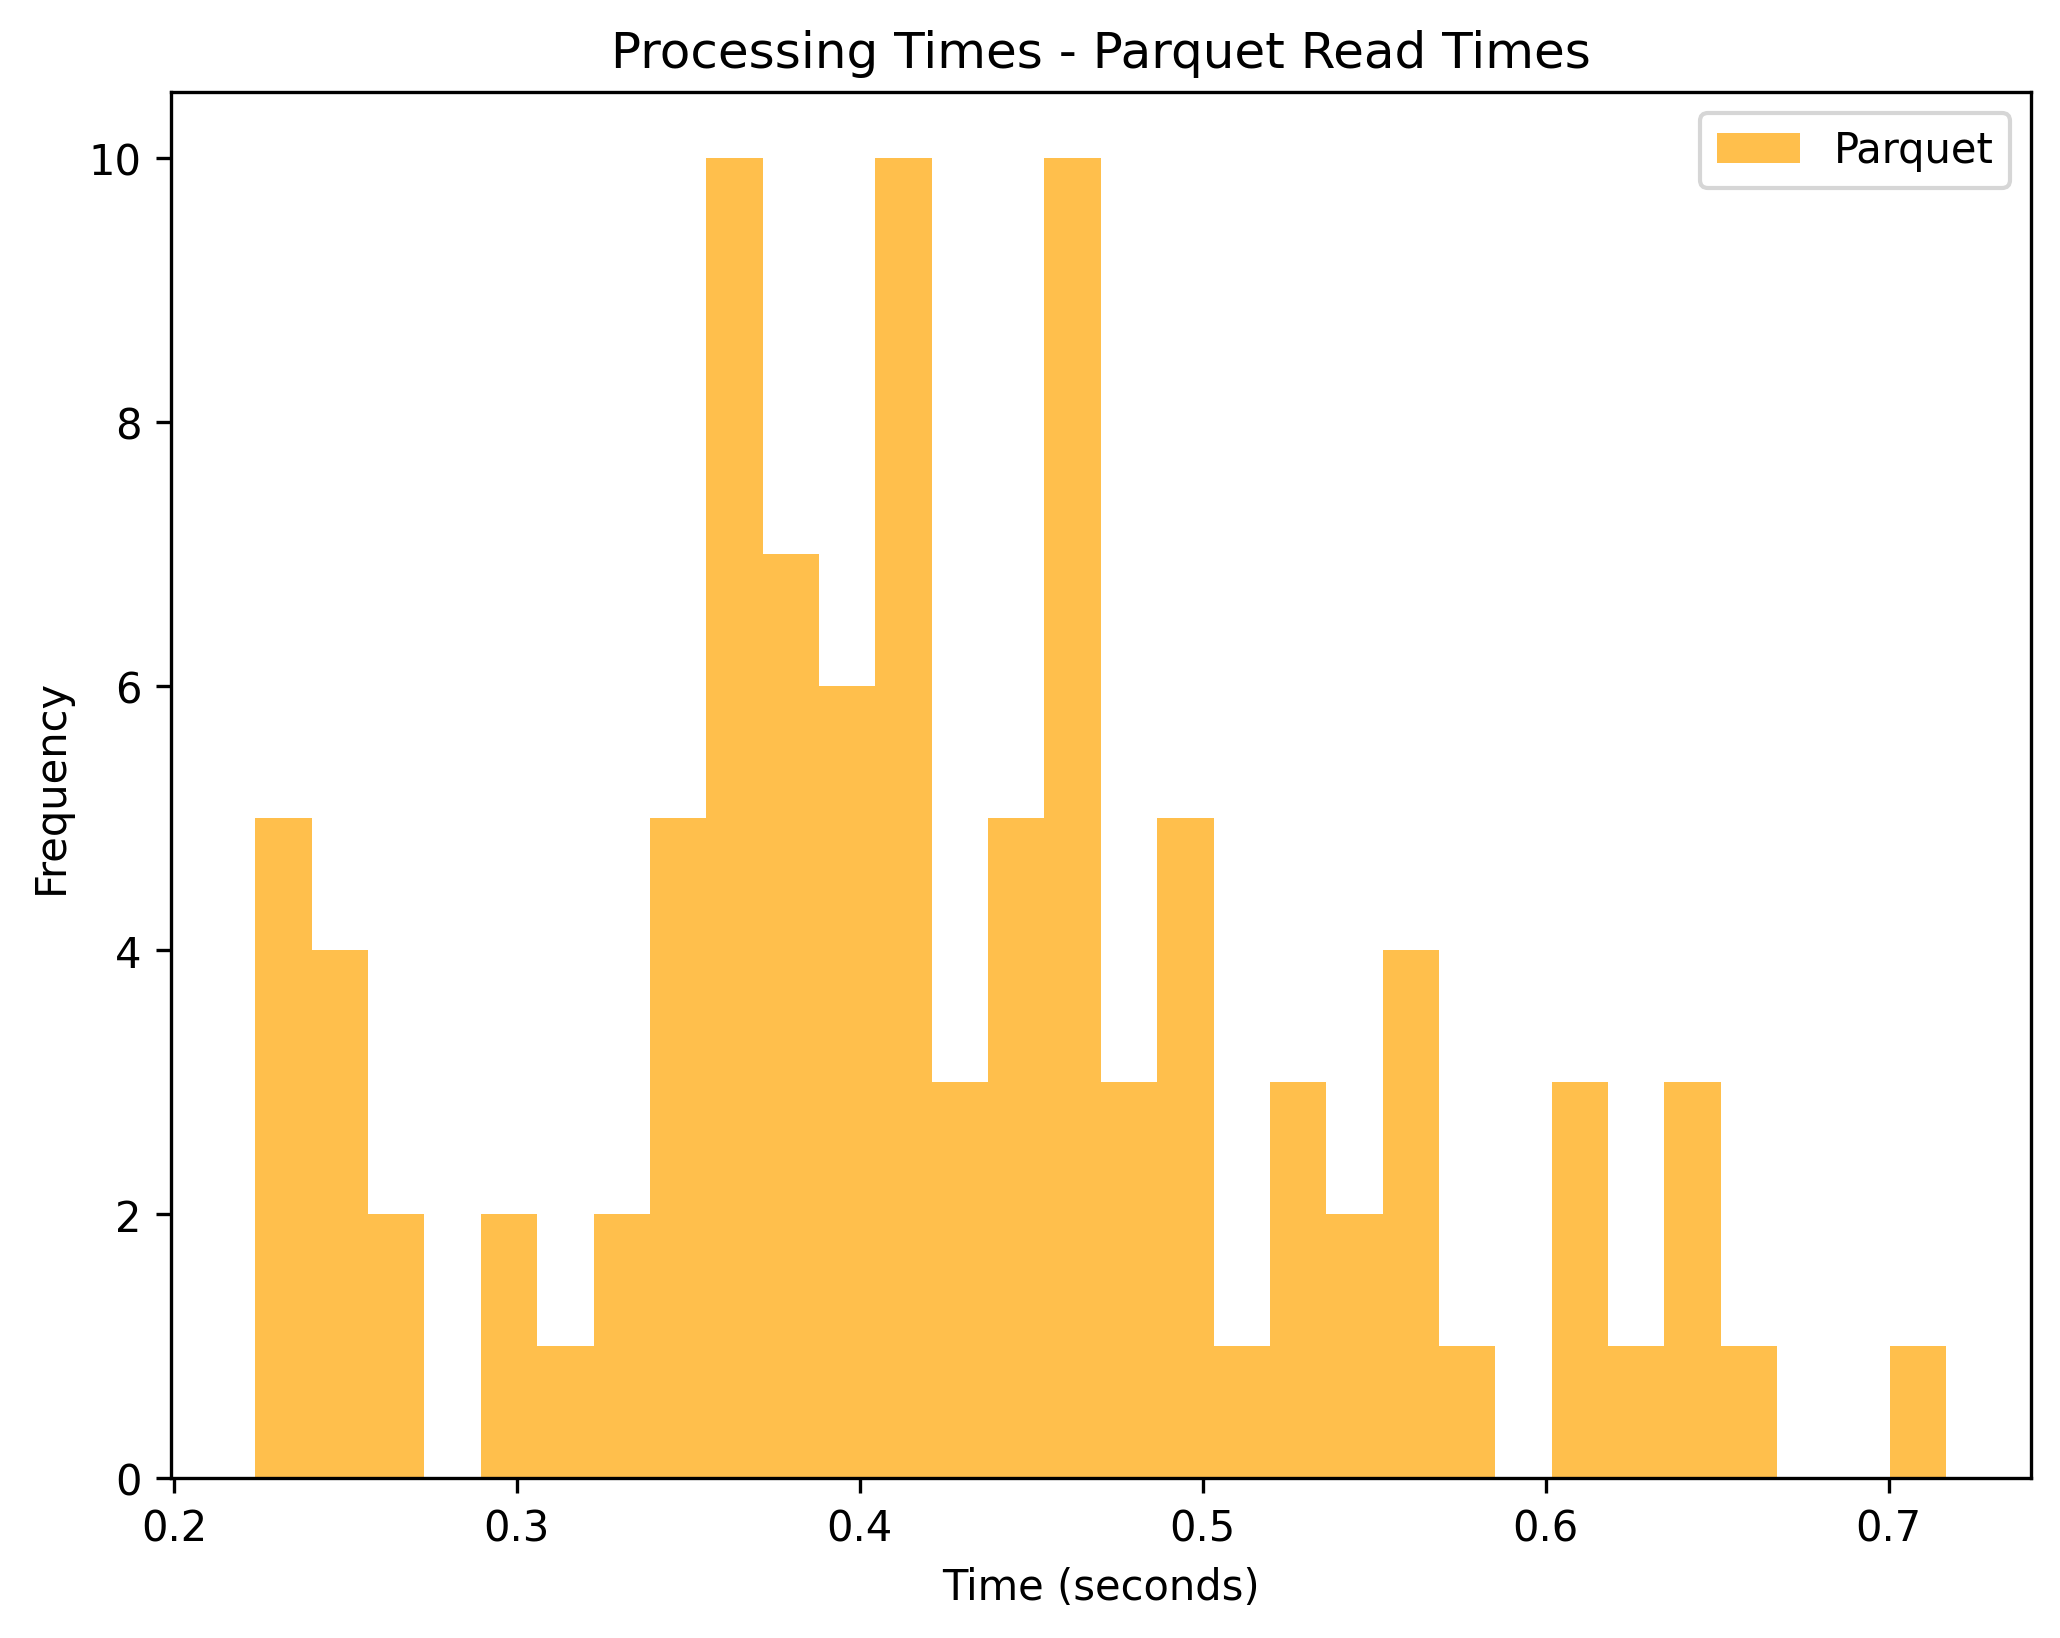

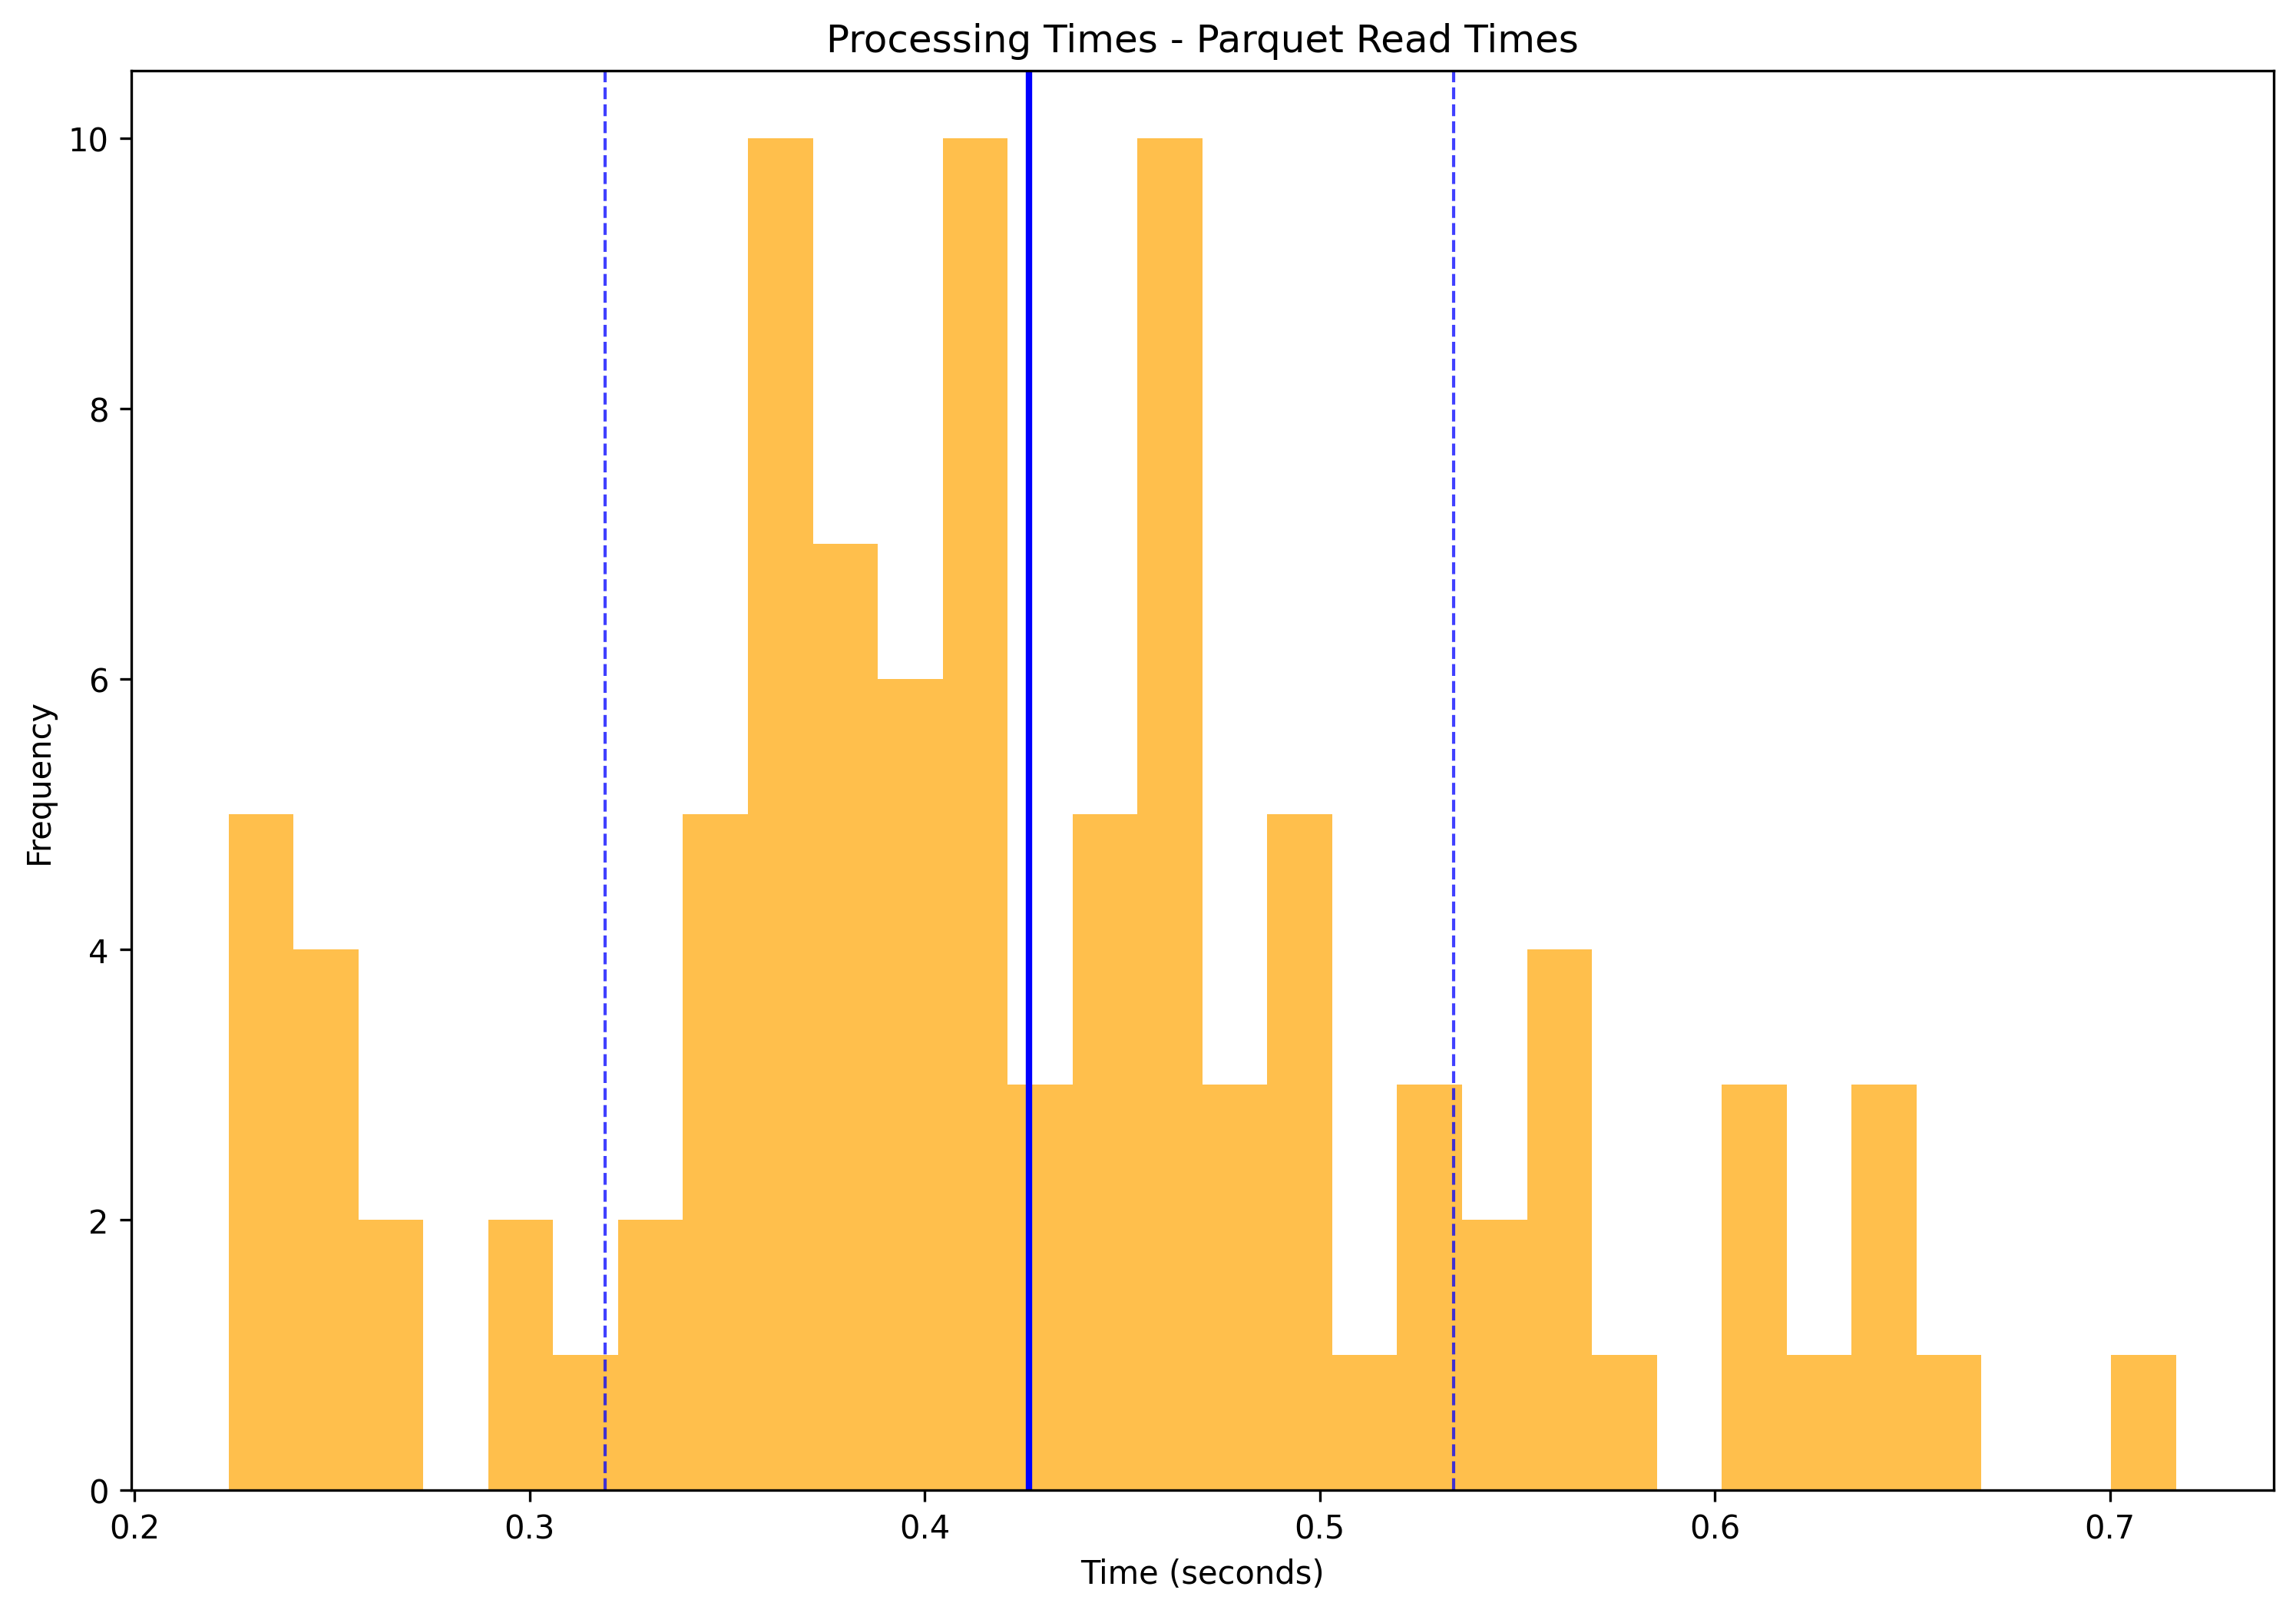

In [56]:
import time
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

parquet_path = '/Users/alexandernez/Desktop/Github/Epymorph_vignettes/scratch/NASA/gpw_v4_population_estimates.parquet'


def read_parquet():
    start_time = time.time()
    gdf = gpd.read_parquet(parquet_path)
    end_time = time.time()
    return end_time - start_time

def main():
    num_iterations = 100
    parquet_durations = []

    print("Starting looping...")

    for _ in range(num_iterations):
        duration = read_parquet()
        parquet_durations.append(duration)

    print("Looping completed.")

    # Calculate statistics for parquet read times
    mean_parquet_duration = np.mean(parquet_durations)
    median_parquet_duration = np.median(parquet_durations)
    std_dev_parquet_duration = np.std(parquet_durations)

    print(f"Parquet Read - Mean duration: {mean_parquet_duration:.4f} seconds")
    print(f"Parquet Read - Median duration: {median_parquet_duration:.4f} seconds")
    print(f"Parquet Read - Standard deviation: {std_dev_parquet_duration:.4f} seconds")

    # Create a histogram of the parquet read times
    plt.figure(figsize=(8, 6), dpi = 300)
    plt.hist(parquet_durations, bins=30, alpha=0.7, label='Parquet', color='orange')
    plt.title('Processing Times - Parquet Read Times')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 8), dpi = 300)
    plt.hist(parquet_durations, bins=30, alpha=0.7, color='orange')
    plt.title('Processing Times - Parquet Read Times')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency')

    # Plot mean duration as a vertical line
    plt.axvline(mean_parquet_duration, color='blue', linestyle='-', linewidth=2)

    # Plot +/- 1 standard deviation as vertical lines
    plt.axvline(mean_parquet_duration + std_dev_parquet_duration, color='blue', alpha = 0.75, linestyle='--', linewidth=1)
    plt.axvline(mean_parquet_duration - std_dev_parquet_duration, color='blue', alpha = 0.75, linestyle='--', linewidth=1)

    plt.show()

if __name__ == "__main__":
    main()


In [ ]:
plt.figure(figsize=(12, 8), dpi = 300)
plt.hist(parquet_durations, bins=30, alpha=0.7, color='orange')
plt.title('Processing Times - Social Centroid')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')

# Plot mean duration as a vertical line
plt.axvline(mean_duration, color='blue', linestyle='-', linewidth=2)

# Plot +/- 1 standard deviation as vertical lines
plt.axvline(mean_duration + std_dev_duration, color='blue', alpha = 0.75, linestyle='--', linewidth=1)
plt.axvline(mean_duration - std_dev_duration, color='blue', alpha = 0.75, linestyle='--', linewidth=1)

plt.show()

In [28]:
import time
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point

parquet_path = '/Users/alexandernez/Desktop/Github/Epymorph_vignettes/scratch/NASA/gpw_v4_population_estimates.parquet'

def read_and_process_parquet():
    start_time = time.time()

    # Read the parquet file
    gdf = gpd.read_parquet(parquet_path)

    county_gdf.loc[:, 'school'] = county_gdf[['A00_04B', 'A05_09B', 'A10_14B', 'A15_19B']].sum(axis=1)
    county_gdf.loc[:, 'adults'] = county_gdf[['A20_24B', 'A25_29B', 'A30_34B', 'A35_39B', 'A40_44B', 'A45_49B', 'A50_54B', 'A55_59B', 'A60_64B']].sum(axis=1)
    county_gdf.loc[:, 'elder'] = county_gdf['A65PLUSB']
    county_gdf.loc[:, 'Population'] = county_gdf[['A00_04B', 'A05_09B', 'A10_14B', 'A15_19B','A20_24B', 'A25_29B', 'A30_34B', 'A35_39B', 'A40_44B', 'A45_49B', 'A50_54B', 'A55_59B', 'A60_64B','A65PLUSB']].sum(axis=1)
    county_gdf.loc[:, 'Population 2020'] = county_gdf['UN_2020_E']

    joined_gdf = gpd.sjoin(county_gdf, census_block_groups, how="inner", op="within")

    aggregated_data = joined_gdf.groupby('index_right').agg({
        'Population 2020': lambda x: list(x),  # Aggregate populations into lists
        'geometry': lambda x: list(x)  # Aggregate geometries into lists
    })

    aggregated_data['Population'] = aggregated_data['Population 2020'].apply(np.array)
    aggregated_data['geometry'] = aggregated_data['geometry'].apply(np.array)

    census_block_groups['Point_Geometries'] = None
    census_block_groups['Populations'] = None

    for idx in aggregated_data.index:
        census_block_groups.at[idx, 'Point_Geometries'] = aggregated_data.at[idx, 'geometry']
        census_block_groups.at[idx, 'Populations'] = aggregated_data.at[idx, 'Population']

    def calculate_weighted_social_centroid(df):
        df['Social_centroid'] = None  # Initialize the column for social centroids

        for idx, row in df.iterrows():
            # Explicitly check if 'Point_Geometries' and 'Populations' are not None or empty by comparing their lengths to zero
            if row['area km^2'] > 500 and row.get('Point_Geometries') is not None and len(row['Point_Geometries']) > 0 and row.get('Populations') is not None and len(row['Populations']) > 0:
                # Ensure 'Point_Geometries' and 'Populations' lists have the same length
                if len(row['Point_Geometries']) == len(row['Populations']):
                    # Calculate weighted latitudes and longitudes
                    weighted_latitudes = [point.y * population for point, population in zip(row['Point_Geometries'], row['Populations'])]
                    weighted_longitudes = [point.x * population for point, population in zip(row['Point_Geometries'], row['Populations'])]
                    # Calculate total population
                    total_population = sum(row['Populations'])

                    # Proceed if total population is greater than 0
                    if total_population > 0:
                        mean_lat = sum(weighted_latitudes) / total_population
                        mean_lon = sum(weighted_longitudes) / total_population
                        # Assign the calculated Point as the social centroid
                        df.at[idx, 'Social_centroid'] = Point(mean_lon, mean_lat)

        return df

    census_block_groups = calculate_weighted_social_centroid(census_block_groups)

    end_time = time.time()
    return census_block_groups, end_time - start_time


def main():
    num_iterations = 100
    parquet_durations = []

    print("Starting looping...")

    for _ in range(num_iterations):
        duration = read_and_process_parquet()
        parquet_durations.append(duration)

    print("Looping completed.")

    # Calculate statistics for parquet read times
    mean_parquet_duration = np.mean(parquet_durations)
    median_parquet_duration = np.median(parquet_durations)
    std_dev_parquet_duration = np.std(parquet_durations)

    print(f"Parquet Read and Process - Mean duration: {mean_parquet_duration:.4f} seconds")
    print(f"Parquet Read and Process - Median duration: {median_parquet_duration:.4f} seconds")
    print(f"Parquet Read and Process - Standard deviation: {std_dev_parquet_duration:.4f} seconds")

    # Create a histogram of the parquet read times
    plt.figure(figsize=(8, 6))
    plt.hist(parquet_durations, bins=30, alpha=0.7, label='Parquet', color='orange')
    plt.title('Histogram of Parquet Read and Process Times')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()


Starting looping...


UnboundLocalError: cannot access local variable 'census_block_groups' where it is not associated with a value

In [ ]:
county_gdf = dummy_arg[0]
    census_block_groups = dummy_arg[1]

    county_gdf.loc[:, 'school'] = county_gdf[['A00_04B', 'A05_09B', 'A10_14B', 'A15_19B']].sum(axis=1)
    county_gdf.loc[:, 'adults'] = county_gdf[['A20_24B', 'A25_29B', 'A30_34B', 'A35_39B', 'A40_44B', 'A45_49B', 'A50_54B', 'A55_59B', 'A60_64B']].sum(axis=1)
    county_gdf.loc[:, 'elder'] = county_gdf['A65PLUSB']
    county_gdf.loc[:, 'Population'] = county_gdf[['A00_04B', 'A05_09B', 'A10_14B', 'A15_19B','A20_24B', 'A25_29B', 'A30_34B', 'A35_39B', 'A40_44B', 'A45_49B', 'A50_54B', 'A55_59B', 'A60_64B','A65PLUSB']].sum(axis=1)
    county_gdf.loc[:, 'Population 2020'] = county_gdf['UN_2020_E']

    # Reproject one of the GeoDataFrames if needed
    census_block_groups = census_block_groups.to_crs(county_gdf.crs)

    joined_gdf = gpd.sjoin(county_gdf, census_block_groups, how="inner", op="within")

    aggregated_data = joined_gdf.groupby('index_right').agg({
        'Population 2020': lambda x: list(x),  # Aggregate populations into lists
        'geometry': lambda x: list(x)  # Aggregate geometries into lists
    })

    aggregated_data['Population'] = aggregated_data['Population 2020'].apply(np.array)
    aggregated_data['geometry'] = aggregated_data['geometry'].apply(np.array)

    census_block_groups['Point_Geometries'] = None
    census_block_groups['Populations'] = None

    for idx in aggregated_data.index:
        census_block_groups.at[idx, 'Point_Geometries'] = aggregated_data.at[idx, 'geometry']
        census_block_groups.at[idx, 'Populations'] = aggregated_data.at[idx, 'Population']

    def calculate_weighted_social_centroid(df):
        df['Social_centroid'] = None  # Initialize the column for social centroids

        for idx, row in df.iterrows():
            # Explicitly check if 'Point_Geometries' and 'Populations' are not None or empty by comparing their lengths to zero
            if row['area km^2'] > 500 and row.get('Point_Geometries') is not None and len(row['Point_Geometries']) > 0 and row.get('Populations') is not None and len(row['Populations']) > 0:
                # Ensure 'Point_Geometries' and 'Populations' lists have the same length
                if len(row['Point_Geometries']) == len(row['Populations']):
                    # Calculate weighted latitudes and longitudes
                    weighted_latitudes = [point.y * population for point, population in zip(row['Point_Geometries'], row['Populations'])]
                    weighted_longitudes = [point.x * population for point, population in zip(row['Point_Geometries'], row['Populations'])]
                    # Calculate total population
                    total_population = sum(row['Populations'])

                    # Proceed if total population is greater than 0
                    if total_population > 0:
                        mean_lat = sum(weighted_latitudes) / total_population
                        mean_lon = sum(weighted_longitudes) / total_population
                        # Assign the calculated Point as the social centroid
                        df.at[idx, 'Social_centroid'] = Point(mean_lon, mean_lat)

        return df

    census_block_groups = calculate_weighted_social_centroid(census_block_groups)

    return census_block_groups

In [ ]:
import time
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from multiprocessing import Pool, get_context
import os

parquet_path = '/Users/alexandernez/Desktop/Github/Epymorph_vignettes/scratch/NASA/gpw_v4_population_estimates.parquet'

def process_data(dummy_arg):
    county_gdf = dummy_arg[0]
    census_block_groups = dummy_arg[1]
    gdf = gpd.read_parquet(parquet_path)
    
    county_gdf.loc[:, 'school'] = county_gdf[['A00_04B', 'A05_09B', 'A10_14B', 'A15_19B']].sum(axis=1)
    county_gdf.loc[:, 'adults'] = county_gdf[['A20_24B', 'A25_29B', 'A30_34B', 'A35_39B', 'A40_44B', 'A45_49B', 'A50_54B', 'A55_59B', 'A60_64B']].sum(axis=1)
    county_gdf.loc[:, 'elder'] = county_gdf['A65PLUSB']
    county_gdf.loc[:, 'Population'] = county_gdf[['A00_04B', 'A05_09B', 'A10_14B', 'A15_19B','A20_24B', 'A25_29B', 'A30_34B', 'A35_39B', 'A40_44B', 'A45_49B', 'A50_54B', 'A55_59B', 'A60_64B','A65PLUSB']].sum(axis=1)
    county_gdf.loc[:, 'Population 2020'] = county_gdf['UN_2020_E']

    # Reproject one of the GeoDataFrames if needed
    census_block_groups = census_block_groups.to_crs(county_gdf.crs)

    joined_gdf = gpd.sjoin(county_gdf, census_block_groups, how="inner", op="within")

    aggregated_data = joined_gdf.groupby('index_right').agg({
        'Population 2020': lambda x: list(x),  # Aggregate populations into lists
        'geometry': lambda x: list(x)  # Aggregate geometries into lists
    })

    aggregated_data['Population'] = aggregated_data['Population 2020'].apply(np.array)
    aggregated_data['geometry'] = aggregated_data['geometry'].apply(np.array)

    census_block_groups['Point_Geometries'] = None
    census_block_groups['Populations'] = None

    for idx in aggregated_data.index:
        census_block_groups.at[idx, 'Point_Geometries'] = aggregated_data.at[idx, 'geometry']
        census_block_groups.at[idx, 'Populations'] = aggregated_data.at[idx, 'Population']

    def calculate_weighted_social_centroid(df):
        df['Social_centroid'] = None  # Initialize the column for social centroids

        for idx, row in df.iterrows():
            # Explicitly check if 'Point_Geometries' and 'Populations' are not None or empty by comparing their lengths to zero
            if row['area km^2'] > 500 and row.get('Point_Geometries') is not None and len(row['Point_Geometries']) > 0 and row.get('Populations') is not None and len(row['Populations']) > 0:
                # Ensure 'Point_Geometries' and 'Populations' lists have the same length
                if len(row['Point_Geometries']) == len(row['Populations']):
                    # Calculate weighted latitudes and longitudes
                    weighted_latitudes = [point.y * population for point, population in zip(row['Point_Geometries'], row['Populations'])]
                    weighted_longitudes = [point.x * population for point, population in zip(row['Point_Geometries'], row['Populations'])]
                    # Calculate total population
                    total_population = sum(row['Populations'])

                    # Proceed if total population is greater than 0
                    if total_population > 0:
                        mean_lat = sum(weighted_latitudes) / total_population
                        mean_lon = sum(weighted_longitudes) / total_population
                        # Assign the calculated Point as the social centroid
                        df.at[idx, 'Social_centroid'] = Point(mean_lon, mean_lat)

        return df

    census_block_groups = calculate_weighted_social_centroid(census_block_groups)

    return census_block_groups

def measure_time(dummy_arg):
    start_time = time.time()
    process_data(dummy_arg)
    end_time = time.time()
    return end_time - start_time

# Sample data for demonstration (Replace with actual data loading)
county_gdf = pd.DataFrame({
    'A00_04B': np.random.randint(0, 100, size=1000),
    'A05_09B': np.random.randint(0, 100, size=1000),
    'A10_14B': np.random.randint(0, 100, size=1000),
    'A15_19B': np.random.randint(0, 100, size=1000),
    'A20_24B': np.random.randint(0, 100, size=1000),
    'A25_29B': np.random.randint(0, 100, size=1000),
    'A30_34B': np.random.randint(0, 100, size=1000),
    'A35_39B': np.random.randint(0, 100, size=1000),
    'A40_44B': np.random.randint(0, 100, size=1000),
    'A45_49B': np.random.randint(0, 100, size=1000),
    'A50_54B': np.random.randint(0, 100, size=1000),
    'A55_59B': np.random.randint(0, 100, size=1000),
    'A60_64B': np.random.randint(0, 100, size=1000),
    'A65PLUSB': np.random.randint(0, 100, size=1000),
    'UN_2020_E': np.random.randint(0, 1000, size=1000),
    'geometry': [Point(np.random.random(), np.random.random()) for _ in range(1000)]
})
county_gdf = gpd.GeoDataFrame(county_gdf, geometry='geometry')

census_block_groups = gpd.GeoDataFrame({
    'area km^2': np.random.random(size=1000) * 1000,
    'geometry': [Point(np.random.random(), np.random.random()) for _ in range(1000)],
    'GEOID': [str(i) for i in range(1000)]
})
census_block_groups = gpd.GeoDataFrame(census_block_groups, geometry='geometry')

# Use multiprocessing to run the function 100 times
cpu_75 = int(0.75 * os.cpu_count())
with get_context("spawn").Pool(cpu_75) as pool:
    durations = pool.map(measure_time, [(county_gdf, census_block_groups)] * 100)

# Calculate statistics
mean_duration = np.mean(durations)
median_duration = np.median(durations)
std_dev_duration = np.std(durations)

print(f"Mean duration: {mean_duration:.4f} seconds")
print(f"Median duration: {median_duration:.4f} seconds")
print(f"Standard deviation: {std_dev_duration:.4f} seconds")

# Plotting the results
plt.figure(figsize=(12, 8))

# Histogram
counts, bins, patches = plt.hist(durations, bins=30, alpha=0.7, label='Durations', color='orange')
plt.title('Histogram of Processing Times')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')

# Calculate mean and std_dev of the frequencies (heights of the bins)
mean_freq = np.mean(counts)
std_dev_freq = np.std(counts)

# Plot mean frequency
plt.axhline(mean_freq, color='blue', linestyle='-', linewidth=2, label='Mean Frequency')

# Plot +/- 1 standard deviation
plt.axhline(mean_freq + std_dev_freq, color='green', linestyle='--', linewidth=1, label='+1 STD')
plt.axhline(mean_freq - std_dev_freq, color='green', linestyle='--', linewidth=1, label='-1 STD')

plt.legend()
plt.show()


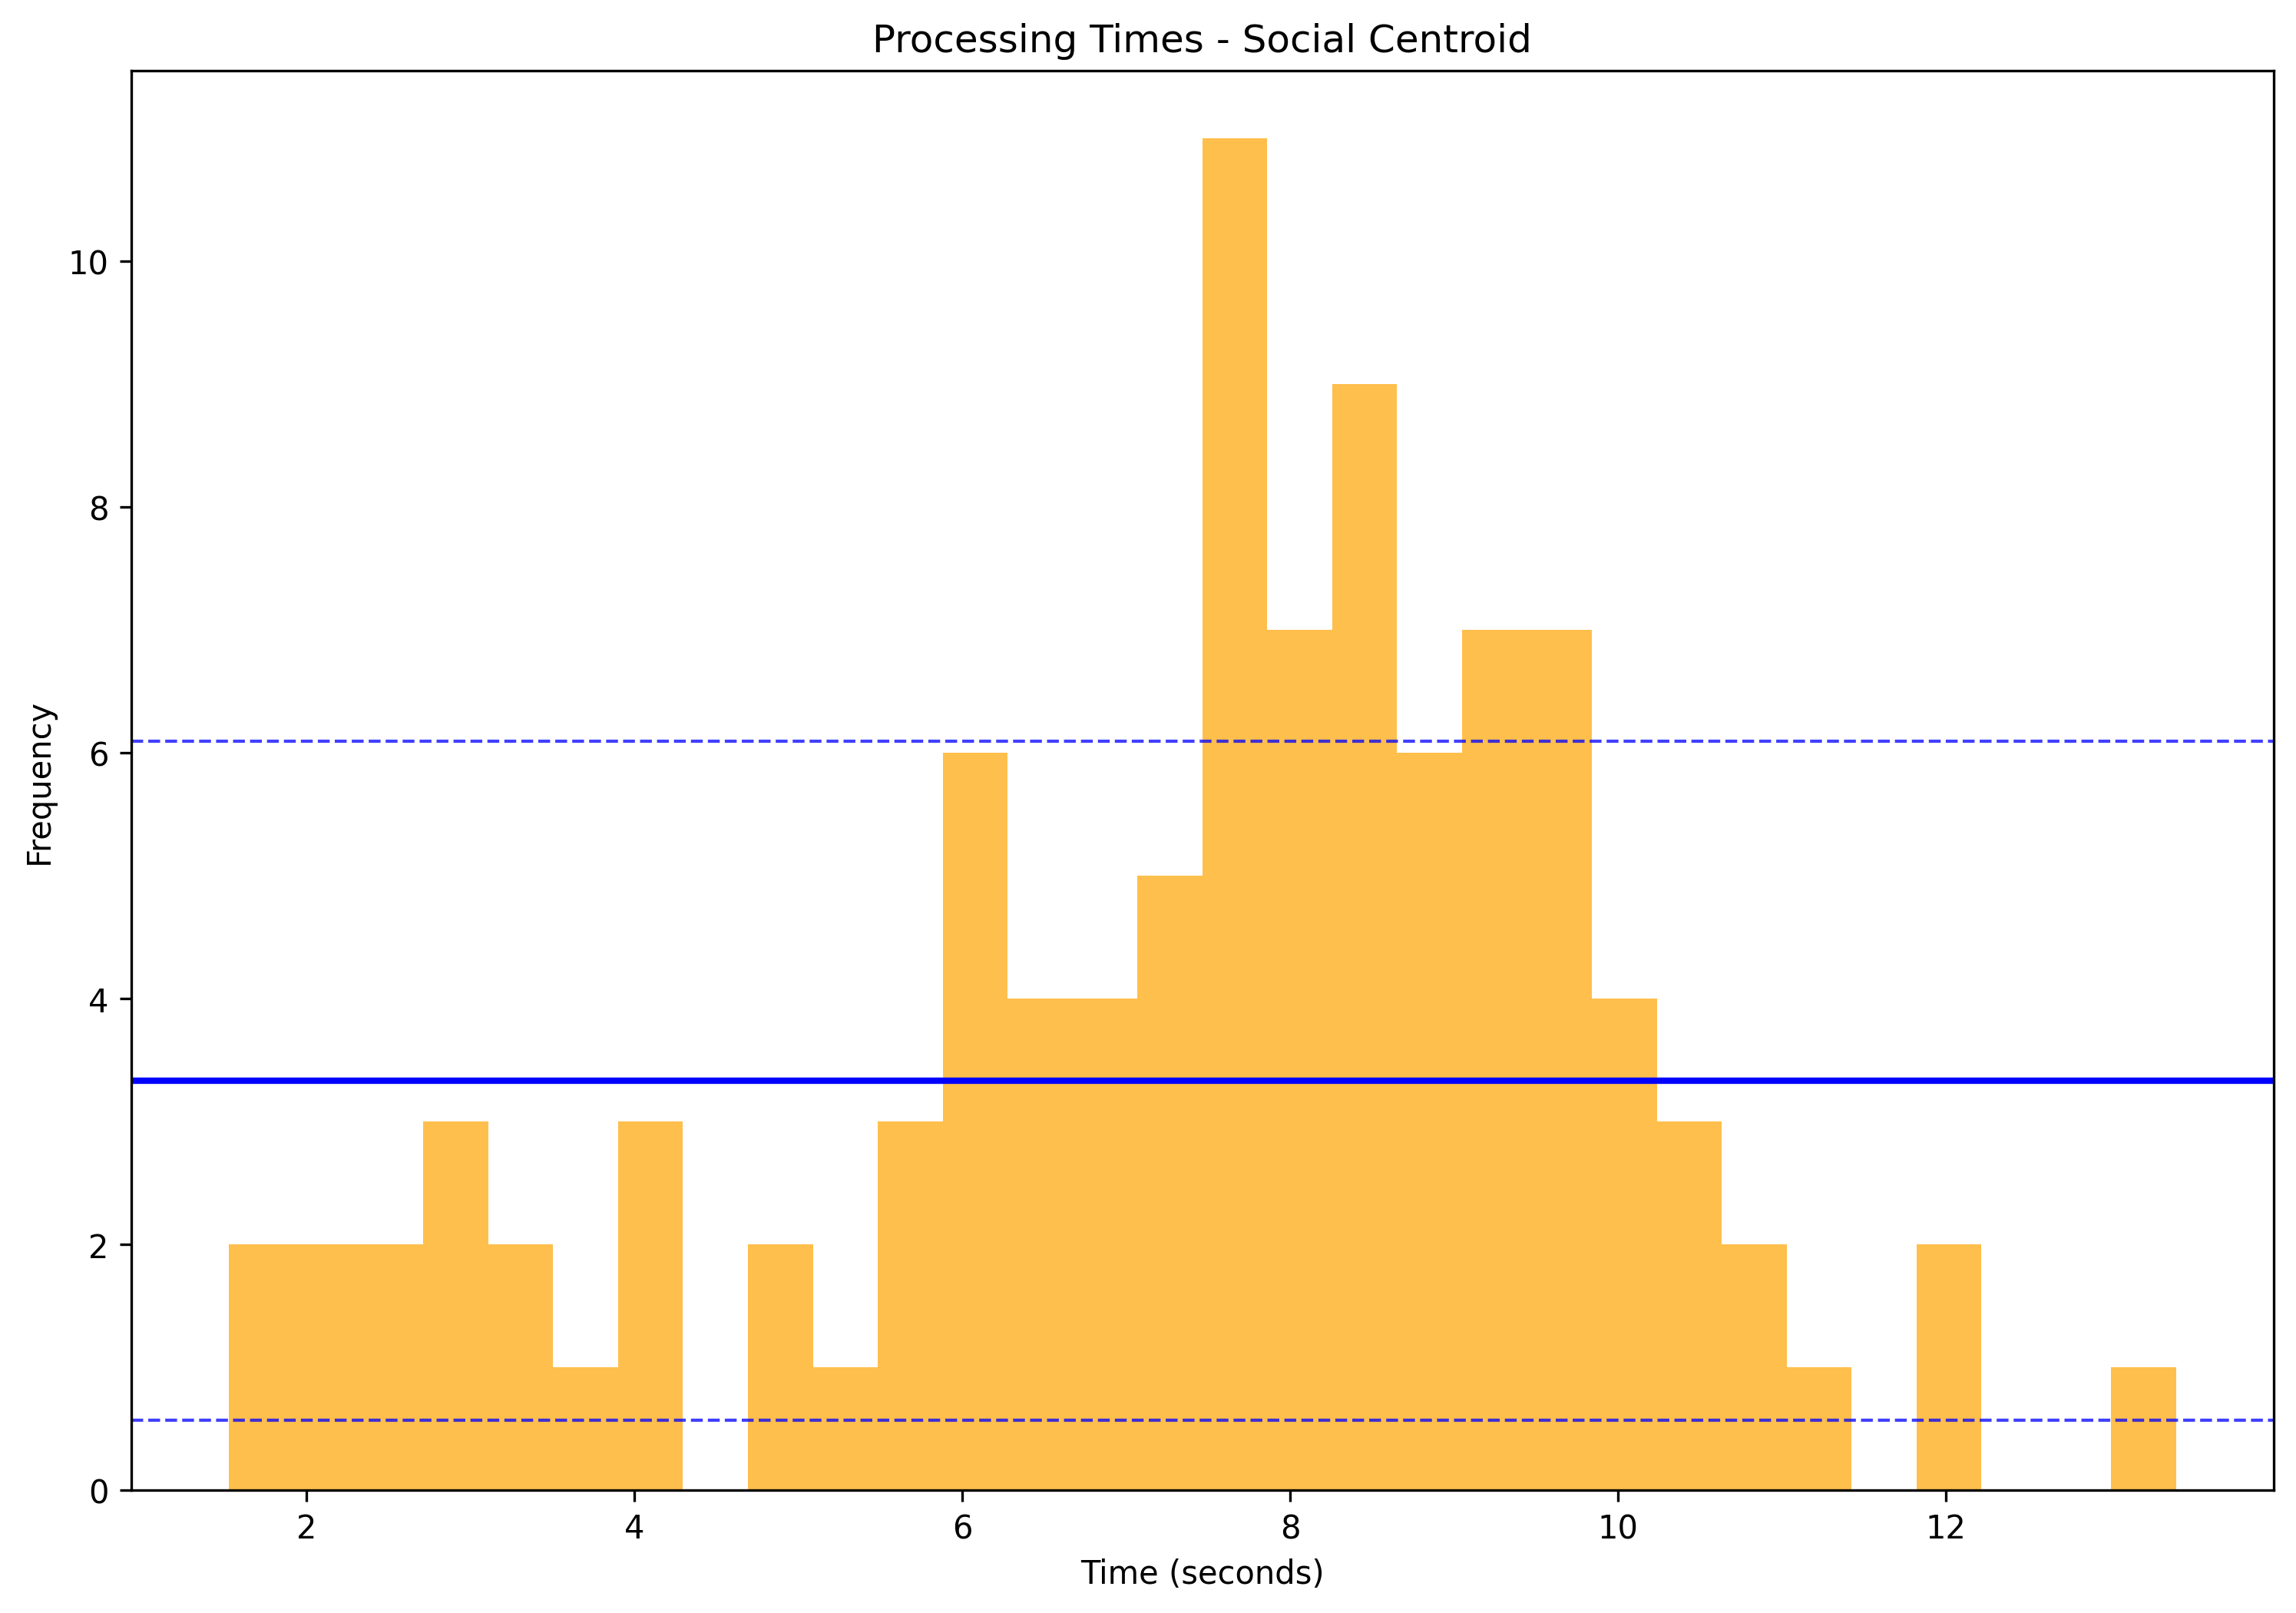

In [45]:
plt.figure(figsize=(12, 8), dpi = 300)

counts, bins, patches = plt.hist(durations, bins=30, alpha=0.7, color='orange')
plt.title('Processing Times - Social Centroid')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')

mean_freq = np.mean(counts)
std_dev_freq = np.std(counts)

plt.axhline(mean_freq, color='blue', linestyle='-', linewidth=2)

plt.axhline(mean_freq + std_dev_freq, color='blue', alpha = 0.75, linestyle='--', linewidth=1)
plt.axhline(mean_freq - std_dev_freq, color='blue', alpha = 0.75, linestyle='--', linewidth=1)

plt.show()


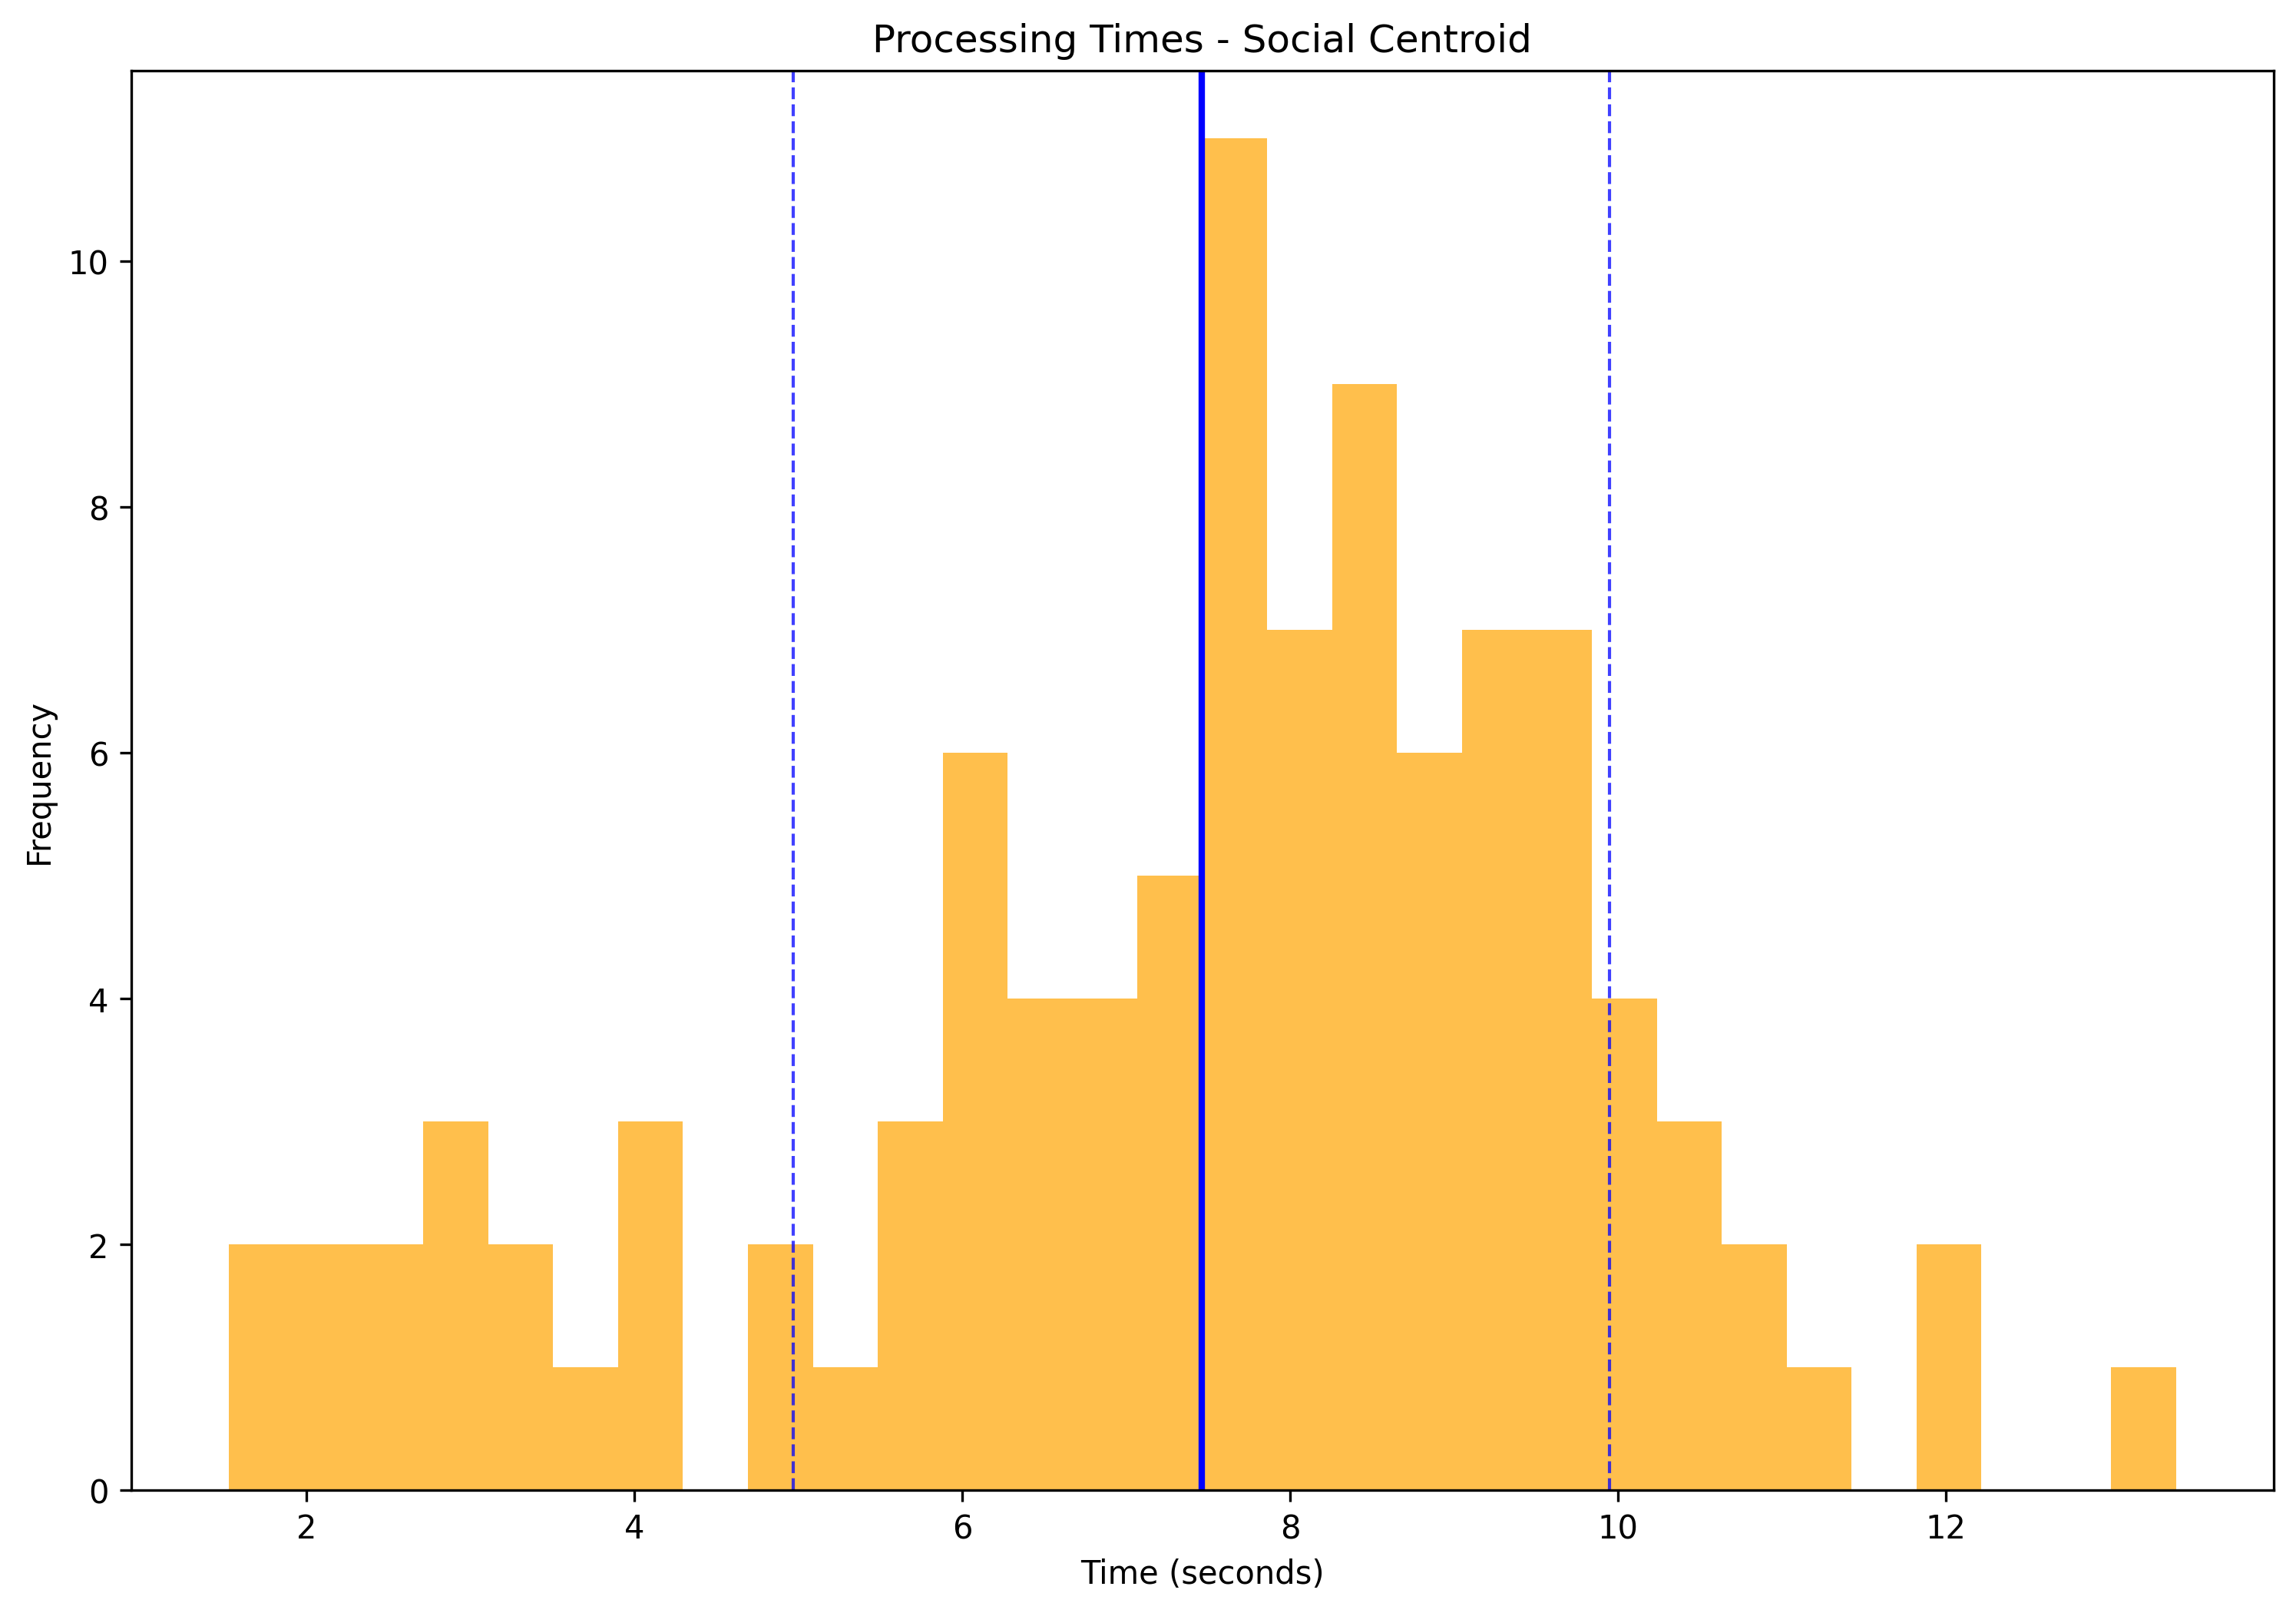

In [49]:
plt.figure(figsize=(12, 8), dpi = 300)
plt.hist(durations, bins=30, alpha=0.7, color='orange')
plt.title('Processing Times - Social Centroid')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency')

# Plot mean duration as a vertical line
plt.axvline(mean_duration, color='blue', linestyle='-', linewidth=2)

# Plot +/- 1 standard deviation as vertical lines
plt.axvline(mean_duration + std_dev_duration, color='blue', alpha = 0.75, linestyle='--', linewidth=1)
plt.axvline(mean_duration - std_dev_duration, color='blue', alpha = 0.75, linestyle='--', linewidth=1)

plt.show()